# Import library and model

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense

# Import, Scale and Split Dataset

In [2]:
# Import Dataset
 # EUR - VND
eur = pd.read_csv('Dataset\EUR_VND.csv')
 # GBP - VND
gbp = pd.read_csv("Dataset\GBP_VND.csv")
 # JPY - VND
jpy = pd.read_csv("Dataset\JPY_VND.csv")
# Convert
eur = eur['Sale'].replace({',':''}, regex=True).astype(float)
gbp = gbp['Sale'].replace({',':''}, regex=True).astype(float)
jpy = jpy['Sale'].replace({',':''}, regex=True).astype(float)

In [3]:
# Scale data
 # Scaler model
scaler=MinMaxScaler(feature_range=(0,1))
 # EUR - VND
eur_sc = scaler.fit_transform(np.array(eur).reshape(-1,1))
 # GBP - VND
gbp_sc = scaler.fit_transform(np.array(gbp).reshape(-1,1))
 # JPY - VND
jpy_sc = scaler.fit_transform(np.array(jpy).reshape(-1,1))

In [4]:
# Split train, test, validate data
#### EUR - VND
  # case 1. 7:3
train_eur_1_sc = eur_sc[:int(0.7*len(eur))]
test_eur_1_sc = eur_sc[int(0.7*len(eur)):]
  # case 2. 8:2
train_eur_2_sc = eur_sc[:int(0.8*len(eur))]
test_eur_2_sc = eur_sc[int(0.8*len(eur)):]
  # case 3. 9:1
train_eur_3_sc = eur_sc[:int(0.9*len(eur))]
test_eur_3_sc = eur_sc[int(0.9*len(eur)):]
#### GBP - VND
  # case 1. 7:3
train_gbp_1_sc = gbp_sc[:int(0.7*len(gbp))]
test_gbp_1_sc = gbp_sc[int(0.7*len(gbp)):]
  # case 2. 8:2
train_gbp_2_sc = gbp_sc[:int(0.8*len(gbp))]
test_gbp_2_sc = gbp_sc[int(0.8*len(gbp)):]
  # case 3. 9:1
train_gbp_3_sc = gbp_sc[:int(0.9*len(gbp))]
test_gbp_3_sc = gbp_sc[int(0.9*len(gbp)):]
#### JPY - VND
  # case 1. 7:3
train_jpy_1_sc = jpy_sc[:int(0.7*len(jpy))]
test_jpy_1_sc = jpy_sc[int(0.7*len(jpy)):]
  # case 2. 8:2
train_jpy_2_sc = jpy_sc[:int(0.8*len(jpy))]
test_jpy_2_sc = jpy_sc[int(0.8*len(jpy)):]
  # case 3. 9:1
train_jpy_3_sc = jpy_sc[:int(0.9*len(jpy))]
test_jpy_3_sc = jpy_sc[int(0.9*len(jpy)):]

# Standardizate function

In [5]:
# Function to standardizate the data
def standardizate_data(train, test, pre_test, f3, f6, f9):
    # Train
    train = np.reshape(train, (-1,1))
    train1 = scaler.inverse_transform(train)
    # Test
    test = np.reshape(test, (-1,1))
    test1 = scaler.inverse_transform(test)
    # Test prediction
    pre_test = np.reshape(pre_test, (-1,1))
    pre_test1 = scaler.inverse_transform(pre_test)
    # Forecast 30
    f3 = np.reshape(f3, (-1,1))
    f3_tf= scaler.inverse_transform(f3)
    # Forecast 60
    f6 = np.reshape(f6, (-1,1))
    f6_tf= scaler.inverse_transform(f6)
    # Forecast 90
    f9 = np.reshape(f9, (-1,1))
    f9_tf= scaler.inverse_transform(f9)
    
    return train1, test1, pre_test1, f3_tf, f6_tf, f9_tf 

# Prepare data

In [6]:
# Function to convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return np.array(dataX), np.array(dataY)

# Forecast

In [7]:
# Function to forecast next 30, 60, 90 days data
def forecast_days(model, test):
    x_input = test[len(test)-100:].reshape(1,-1)

    temp_input=list(x_input)
    temp_input=temp_input[0].tolist()

    forecast30 = []
    forecast60 = []
    forecast90 = []
    n_steps=100
    i=0
    while(i<=90):
        if(len(temp_input)>100):
            x_input=np.array(temp_input[1:])
            print("{} day input {}".format(i,x_input))
            x_input = x_input.reshape(1,-1)
            yhat = model.predict(x_input, verbose=0)
            print("{} day output {}".format(i,yhat))
            temp_input.extend(yhat[0].tolist())
            temp_input=temp_input[1:]
            if i <= 30:
                forecast30.extend(yhat.tolist())
            elif i <= 60:
                forecast60.extend(yhat.tolist())
            else:
                forecast90.extend(yhat.tolist())
            i=i+1
        else:
            yhat = model.predict(x_input, verbose=0)
            print(yhat[0])
            temp_input.extend(yhat[0].tolist())
            print(len(temp_input))
            forecast30.extend(yhat.tolist())
            i=i+1
    return forecast30, forecast60, forecast90

# Visualize

In [8]:
# Function to visualize the model
def visualize_RNN(model, train, test, pre_test, f3, f6, f9):
    # set index
    train_index = pd.RangeIndex(start=0, stop=len(train), step=1)
    test_index = pd.RangeIndex(start=len(train), stop=len(train)+len(test), step=1) 
    pre_test_index = pd.RangeIndex(start=len(train)+101, stop=len(train)+len(test), step=1)
    f3_index = pd.RangeIndex(start=len(train)+len(test)-1, stop=len(train)+len(test)+30, step=1)
    f6_index = pd.RangeIndex(start=len(train)+len(test)+30, stop=len(train)+len(test)+60, step=1)
    f9_index = pd.RangeIndex(start=len(train)+len(test)+60, stop=len(train)+len(test)+90, step=1)
    
    # Visualize
    plt.figure(figsize=(12, 6))
    plt.plot(train_index, scaler.inverse_transform(train))
    plt.plot(test_index, scaler.inverse_transform(test))
    plt.plot(pre_test_index,scaler.inverse_transform(pre_test))
    plt.plot(f3_index, scaler.inverse_transform(f3))
    plt.plot(f6_index, scaler.inverse_transform(f6))
    plt.plot(f9_index, scaler.inverse_transform(f9))
    plt.title('MLP Time Series Forecast')
    plt.xlabel('Date')
    plt.ylabel('Exchange Rate (VND)')
    plt.legend(['Train','Test','TestPred','Forecast 30 days next','Forecast 60 days next','Forecast 90 days next'])
    plt.show()

# Evaluate

In [9]:
# Function to evaluate the model
def evaluate(forecast, actual):
    forecast = np.array(forecast)
    actual = np.array(actual)
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))*100  # MAPE
    mae = np.mean(np.abs(forecast - actual))    # MAE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE

    print('RMSE =',rmse)
    print('MAPE =',mape)
    print('MAE =',mae)

# Implement

In [10]:
def implement_MLP(train, test):
    n_steps = 100
    
    # Convert train and test data
    X_train, y_train = create_dataset(train, n_steps)
    X_test, y_test = create_dataset(test, n_steps)
    
    # Define MLP model
    model = Sequential()
    model.add(Dense(100, activation='relu', input_dim=n_steps))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    
    # Fit model
    model.fit(X_train, y_train,validation_data=(X_test,y_test), epochs=100, batch_size=64, verbose=0)
    
    # Predict test data
    pre_test = model.predict(X_test)
    
    # Forecast next 30, 60, 90 days
    forecast30, forecast60, forecast90 = forecast_days(model, test)
    
    # Visualize model
    visualize_RNN(model, train, test, pre_test, forecast30, forecast60, forecast90)

    # Standardizate
    train, test, pre_test, forecast30, forecast60, forecast90 = standardizate_data(train, test, pre_test, forecast30, forecast60, forecast90)

    # Measure accurancy
    test1 = test[101:]
    print('- Test: ')
    evaluate(pre_test, test1)

# EUR - VND

- **Case 1. 7:3**

C:\Users\TTMC\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
[0.68236935]
101
1 day input [0.67132991 0.67132991 0.67132991 0.68408004 0.68284045 0.70161148
 0.68142376 0.66920489 0.66920489 0.66920489 0.65078803 0.64087126
 0.62156897 0.61607933 0.60651673 0.60651673 0.60651673 0.60208961
 0.61572516 0.61962104 0.66495484 0.69045511 0.69045511 0.69045511
 0.69328847 0.70391358 0.70462192 0.69612183 0.70586152 0.70586152
 0.70586152 0.7156012  0.72321587 0.74340358 0.75934124 0.72534089
 0.72534089 0.72534089 0.72675757 0.73649726 0.70426775 0.7108199
 0.69488224 0.69488224 0.69488224 0.69116345 0.70019479 0.71471578
 0.7311847  0.74057021 0.74057021 0.74057021 0.72604923 0.71383035
 0.7012573  0.70798654 0.7072782  0.7072782  0.7072782  0.71737206
 0.71648663 0.72073667 0.72976802 0.70391358 0.70391358 0.70391358
 0.68691341 0.65344431 0.66477776 0.64582964 0.67115282 0.67115282
 0.67115282 0.62652736 0.61590225 0.63591287 0.6415796  0.63998583
 0.63998583 0.63998583 0.64140251 0.6367983  0.60917301 0.627

8 day output [[0.5754208]]
9 day input [0.66920489 0.66920489 0.65078803 0.64087126 0.62156897 0.61607933
 0.60651673 0.60651673 0.60651673 0.60208961 0.61572516 0.61962104
 0.66495484 0.69045511 0.69045511 0.69045511 0.69328847 0.70391358
 0.70462192 0.69612183 0.70586152 0.70586152 0.70586152 0.7156012
 0.72321587 0.74340358 0.75934124 0.72534089 0.72534089 0.72534089
 0.72675757 0.73649726 0.70426775 0.7108199  0.69488224 0.69488224
 0.69488224 0.69116345 0.70019479 0.71471578 0.7311847  0.74057021
 0.74057021 0.74057021 0.72604923 0.71383035 0.7012573  0.70798654
 0.7072782  0.7072782  0.7072782  0.71737206 0.71648663 0.72073667
 0.72976802 0.70391358 0.70391358 0.70391358 0.68691341 0.65344431
 0.66477776 0.64582964 0.67115282 0.67115282 0.67115282 0.62652736
 0.61590225 0.63591287 0.6415796  0.63998583 0.63998583 0.63998583
 0.64140251 0.6367983  0.60917301 0.62705862 0.66265274 0.66265274
 0.66265274 0.66584027 0.6607048  0.66973614 0.71524703 0.70940322
 0.70940322 0.70940322 0

19 day output [[0.46980095]]
20 day input [0.61962104 0.66495484 0.69045511 0.69045511 0.69045511 0.69328847
 0.70391358 0.70462192 0.69612183 0.70586152 0.70586152 0.70586152
 0.7156012  0.72321587 0.74340358 0.75934124 0.72534089 0.72534089
 0.72534089 0.72675757 0.73649726 0.70426775 0.7108199  0.69488224
 0.69488224 0.69488224 0.69116345 0.70019479 0.71471578 0.7311847
 0.74057021 0.74057021 0.74057021 0.72604923 0.71383035 0.7012573
 0.70798654 0.7072782  0.7072782  0.7072782  0.71737206 0.71648663
 0.72073667 0.72976802 0.70391358 0.70391358 0.70391358 0.68691341
 0.65344431 0.66477776 0.64582964 0.67115282 0.67115282 0.67115282
 0.62652736 0.61590225 0.63591287 0.6415796  0.63998583 0.63998583
 0.63998583 0.64140251 0.6367983  0.60917301 0.62705862 0.66265274
 0.66265274 0.66265274 0.66584027 0.6607048  0.66973614 0.71524703
 0.70940322 0.70940322 0.70940322 0.71985125 0.7168408  0.69559058
 0.71489286 0.69966354 0.68236935 0.67140156 0.65745497 0.64137107
 0.63787287 0.61724168

29 day output [[0.36390036]]
30 day input [0.70586152 0.70586152 0.7156012  0.72321587 0.74340358 0.75934124
 0.72534089 0.72534089 0.72534089 0.72675757 0.73649726 0.70426775
 0.7108199  0.69488224 0.69488224 0.69488224 0.69116345 0.70019479
 0.71471578 0.7311847  0.74057021 0.74057021 0.74057021 0.72604923
 0.71383035 0.7012573  0.70798654 0.7072782  0.7072782  0.7072782
 0.71737206 0.71648663 0.72073667 0.72976802 0.70391358 0.70391358
 0.70391358 0.68691341 0.65344431 0.66477776 0.64582964 0.67115282
 0.67115282 0.67115282 0.62652736 0.61590225 0.63591287 0.6415796
 0.63998583 0.63998583 0.63998583 0.64140251 0.6367983  0.60917301
 0.62705862 0.66265274 0.66265274 0.66265274 0.66584027 0.6607048
 0.66973614 0.71524703 0.70940322 0.70940322 0.70940322 0.71985125
 0.7168408  0.69559058 0.71489286 0.69966354 0.68236935 0.67140156
 0.65745497 0.64137107 0.63787287 0.61724168 0.61356288 0.59431183
 0.5754208  0.56049395 0.55874717 0.533921   0.51107943 0.49145636
 0.49779272 0.47708002 

40 day output [[0.27081728]]
41 day input [0.70426775 0.7108199  0.69488224 0.69488224 0.69488224 0.69116345
 0.70019479 0.71471578 0.7311847  0.74057021 0.74057021 0.74057021
 0.72604923 0.71383035 0.7012573  0.70798654 0.7072782  0.7072782
 0.7072782  0.71737206 0.71648663 0.72073667 0.72976802 0.70391358
 0.70391358 0.70391358 0.68691341 0.65344431 0.66477776 0.64582964
 0.67115282 0.67115282 0.67115282 0.62652736 0.61590225 0.63591287
 0.6415796  0.63998583 0.63998583 0.63998583 0.64140251 0.6367983
 0.60917301 0.62705862 0.66265274 0.66265274 0.66265274 0.66584027
 0.6607048  0.66973614 0.71524703 0.70940322 0.70940322 0.70940322
 0.71985125 0.7168408  0.69559058 0.71489286 0.69966354 0.68236935
 0.67140156 0.65745497 0.64137107 0.63787287 0.61724168 0.61356288
 0.59431183 0.5754208  0.56049395 0.55874717 0.533921   0.51107943
 0.49145636 0.49779272 0.47708002 0.4594304  0.47301352 0.46615794
 0.46980095 0.43670917 0.42888799 0.4128111  0.40847823 0.38956612
 0.38078043 0.37705013

50 day output [[0.28879687]]
51 day input [0.74057021 0.74057021 0.72604923 0.71383035 0.7012573  0.70798654
 0.7072782  0.7072782  0.7072782  0.71737206 0.71648663 0.72073667
 0.72976802 0.70391358 0.70391358 0.70391358 0.68691341 0.65344431
 0.66477776 0.64582964 0.67115282 0.67115282 0.67115282 0.62652736
 0.61590225 0.63591287 0.6415796  0.63998583 0.63998583 0.63998583
 0.64140251 0.6367983  0.60917301 0.62705862 0.66265274 0.66265274
 0.66265274 0.66584027 0.6607048  0.66973614 0.71524703 0.70940322
 0.70940322 0.70940322 0.71985125 0.7168408  0.69559058 0.71489286
 0.69966354 0.68236935 0.67140156 0.65745497 0.64137107 0.63787287
 0.61724168 0.61356288 0.59431183 0.5754208  0.56049395 0.55874717
 0.533921   0.51107943 0.49145636 0.49779272 0.47708002 0.4594304
 0.47301352 0.46615794 0.46980095 0.43670917 0.42888799 0.4128111
 0.40847823 0.38956612 0.38078043 0.37705013 0.37614182 0.35813561
 0.36390036 0.35765824 0.34011784 0.33923522 0.33172277 0.31365526
 0.29146737 0.28800476

60 day output [[0.29881573]]
61 day input [0.71648663 0.72073667 0.72976802 0.70391358 0.70391358 0.70391358
 0.68691341 0.65344431 0.66477776 0.64582964 0.67115282 0.67115282
 0.67115282 0.62652736 0.61590225 0.63591287 0.6415796  0.63998583
 0.63998583 0.63998583 0.64140251 0.6367983  0.60917301 0.62705862
 0.66265274 0.66265274 0.66265274 0.66584027 0.6607048  0.66973614
 0.71524703 0.70940322 0.70940322 0.70940322 0.71985125 0.7168408
 0.69559058 0.71489286 0.69966354 0.68236935 0.67140156 0.65745497
 0.64137107 0.63787287 0.61724168 0.61356288 0.59431183 0.5754208
 0.56049395 0.55874717 0.533921   0.51107943 0.49145636 0.49779272
 0.47708002 0.4594304  0.47301352 0.46615794 0.46980095 0.43670917
 0.42888799 0.4128111  0.40847823 0.38956612 0.38078043 0.37705013
 0.37614182 0.35813561 0.36390036 0.35765824 0.34011784 0.33923522
 0.33172277 0.31365526 0.29146737 0.28800476 0.27881259 0.27480188
 0.27689052 0.27081728 0.25704053 0.26078415 0.26801646 0.27700335
 0.27933753 0.2875081 

70 day output [[0.15247378]]
71 day input [0.67115282 0.67115282 0.67115282 0.62652736 0.61590225 0.63591287
 0.6415796  0.63998583 0.63998583 0.63998583 0.64140251 0.6367983
 0.60917301 0.62705862 0.66265274 0.66265274 0.66265274 0.66584027
 0.6607048  0.66973614 0.71524703 0.70940322 0.70940322 0.70940322
 0.71985125 0.7168408  0.69559058 0.71489286 0.69966354 0.68236935
 0.67140156 0.65745497 0.64137107 0.63787287 0.61724168 0.61356288
 0.59431183 0.5754208  0.56049395 0.55874717 0.533921   0.51107943
 0.49145636 0.49779272 0.47708002 0.4594304  0.47301352 0.46615794
 0.46980095 0.43670917 0.42888799 0.4128111  0.40847823 0.38956612
 0.38078043 0.37705013 0.37614182 0.35813561 0.36390036 0.35765824
 0.34011784 0.33923522 0.33172277 0.31365526 0.29146737 0.28800476
 0.27881259 0.27480188 0.27689052 0.27081728 0.25704053 0.26078415
 0.26801646 0.27700335 0.27933753 0.2875081  0.28746095 0.2989504
 0.29797497 0.28879687 0.29390144 0.30893165 0.30480221 0.29734796
 0.30411816 0.30438739

79 day output [[0.02572617]]
80 day input [0.63998583 0.64140251 0.6367983  0.60917301 0.62705862 0.66265274
 0.66265274 0.66265274 0.66584027 0.6607048  0.66973614 0.71524703
 0.70940322 0.70940322 0.70940322 0.71985125 0.7168408  0.69559058
 0.71489286 0.69966354 0.68236935 0.67140156 0.65745497 0.64137107
 0.63787287 0.61724168 0.61356288 0.59431183 0.5754208  0.56049395
 0.55874717 0.533921   0.51107943 0.49145636 0.49779272 0.47708002
 0.4594304  0.47301352 0.46615794 0.46980095 0.43670917 0.42888799
 0.4128111  0.40847823 0.38956612 0.38078043 0.37705013 0.37614182
 0.35813561 0.36390036 0.35765824 0.34011784 0.33923522 0.33172277
 0.31365526 0.29146737 0.28800476 0.27881259 0.27480188 0.27689052
 0.27081728 0.25704053 0.26078415 0.26801646 0.27700335 0.27933753
 0.2875081  0.28746095 0.2989504  0.29797497 0.28879687 0.29390144
 0.30893165 0.30480221 0.29734796 0.30411816 0.30438739 0.30122527
 0.30167675 0.29582572 0.29881573 0.27907652 0.27157676 0.26921031
 0.24661478 0.242872

87 day output [[-0.1367008]]
88 day input [ 0.66584027  0.6607048   0.66973614  0.71524703  0.70940322  0.70940322
  0.70940322  0.71985125  0.7168408   0.69559058  0.71489286  0.69966354
  0.68236935  0.67140156  0.65745497  0.64137107  0.63787287  0.61724168
  0.61356288  0.59431183  0.5754208   0.56049395  0.55874717  0.533921
  0.51107943  0.49145636  0.49779272  0.47708002  0.4594304   0.47301352
  0.46615794  0.46980095  0.43670917  0.42888799  0.4128111   0.40847823
  0.38956612  0.38078043  0.37705013  0.37614182  0.35813561  0.36390036
  0.35765824  0.34011784  0.33923522  0.33172277  0.31365526  0.29146737
  0.28800476  0.27881259  0.27480188  0.27689052  0.27081728  0.25704053
  0.26078415  0.26801646  0.27700335  0.27933753  0.2875081   0.28746095
  0.2989504   0.29797497  0.28879687  0.29390144  0.30893165  0.30480221
  0.29734796  0.30411816  0.30438739  0.30122527  0.30167675  0.29582572
  0.29881573  0.27907652  0.27157676  0.26921031  0.24661478  0.24287267
  0.2272843

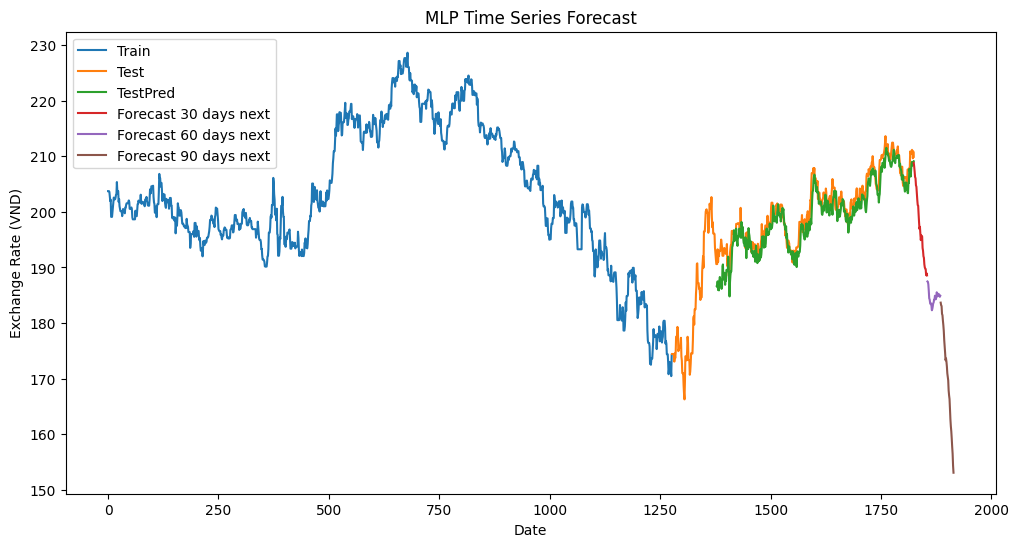

- Test: 
RMSE = 2.4173685002440672
MAPE = 0.9383125346068645
MAE = 1.879675658740974


In [11]:
implement_MLP(train_eur_1_sc, test_eur_1_sc)

- **Case 2. 8:2**

C:\Users\TTMC\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
[0.65406024]
101
1 day input [0.67132991 0.67132991 0.67132991 0.68408004 0.68284045 0.70161148
 0.68142376 0.66920489 0.66920489 0.66920489 0.65078803 0.64087126
 0.62156897 0.61607933 0.60651673 0.60651673 0.60651673 0.60208961
 0.61572516 0.61962104 0.66495484 0.69045511 0.69045511 0.69045511
 0.69328847 0.70391358 0.70462192 0.69612183 0.70586152 0.70586152
 0.70586152 0.7156012  0.72321587 0.74340358 0.75934124 0.72534089
 0.72534089 0.72534089 0.72675757 0.73649726 0.70426775 0.7108199
 0.69488224 0.69488224 0.69488224 0.69116345 0.70019479 0.71471578
 0.7311847  0.74057021 0.74057021 0.74057021 0.72604923 0.71383035
 0.7012573  0.70798654 0.7072782  0.7072782  0.7072782  0.71737206
 0.71648663 0.72073667 0.72976802 0.70391358 0.70391358 0.70391358
 0.68691341 0.65344431 0.66477776 0.64582964 0.67115282 0.67115282
 0.67115282 0.62652736 0.61590225 0.63591287 0.6415796  0.63998583
 0.63998583 0.63998583 0.64140251 0.6367983  0.60917301 0.62705

9 day output [[0.46641234]]
10 day input [0.66920489 0.65078803 0.64087126 0.62156897 0.61607933 0.60651673
 0.60651673 0.60651673 0.60208961 0.61572516 0.61962104 0.66495484
 0.69045511 0.69045511 0.69045511 0.69328847 0.70391358 0.70462192
 0.69612183 0.70586152 0.70586152 0.70586152 0.7156012  0.72321587
 0.74340358 0.75934124 0.72534089 0.72534089 0.72534089 0.72675757
 0.73649726 0.70426775 0.7108199  0.69488224 0.69488224 0.69488224
 0.69116345 0.70019479 0.71471578 0.7311847  0.74057021 0.74057021
 0.74057021 0.72604923 0.71383035 0.7012573  0.70798654 0.7072782
 0.7072782  0.7072782  0.71737206 0.71648663 0.72073667 0.72976802
 0.70391358 0.70391358 0.70391358 0.68691341 0.65344431 0.66477776
 0.64582964 0.67115282 0.67115282 0.67115282 0.62652736 0.61590225
 0.63591287 0.6415796  0.63998583 0.63998583 0.63998583 0.64140251
 0.6367983  0.60917301 0.62705862 0.66265274 0.66265274 0.66265274
 0.66584027 0.6607048  0.66973614 0.71524703 0.70940322 0.70940322
 0.70940322 0.71985125

19 day output [[0.33219782]]
20 day input [0.61962104 0.66495484 0.69045511 0.69045511 0.69045511 0.69328847
 0.70391358 0.70462192 0.69612183 0.70586152 0.70586152 0.70586152
 0.7156012  0.72321587 0.74340358 0.75934124 0.72534089 0.72534089
 0.72534089 0.72675757 0.73649726 0.70426775 0.7108199  0.69488224
 0.69488224 0.69488224 0.69116345 0.70019479 0.71471578 0.7311847
 0.74057021 0.74057021 0.74057021 0.72604923 0.71383035 0.7012573
 0.70798654 0.7072782  0.7072782  0.7072782  0.71737206 0.71648663
 0.72073667 0.72976802 0.70391358 0.70391358 0.70391358 0.68691341
 0.65344431 0.66477776 0.64582964 0.67115282 0.67115282 0.67115282
 0.62652736 0.61590225 0.63591287 0.6415796  0.63998583 0.63998583
 0.63998583 0.64140251 0.6367983  0.60917301 0.62705862 0.66265274
 0.66265274 0.66265274 0.66584027 0.6607048  0.66973614 0.71524703
 0.70940322 0.70940322 0.70940322 0.71985125 0.7168408  0.69559058
 0.71489286 0.69966354 0.65406024 0.62463433 0.60108864 0.58382976
 0.5614602  0.54228145

29 day output [[0.25482813]]
30 day input [0.70586152 0.70586152 0.7156012  0.72321587 0.74340358 0.75934124
 0.72534089 0.72534089 0.72534089 0.72675757 0.73649726 0.70426775
 0.7108199  0.69488224 0.69488224 0.69488224 0.69116345 0.70019479
 0.71471578 0.7311847  0.74057021 0.74057021 0.74057021 0.72604923
 0.71383035 0.7012573  0.70798654 0.7072782  0.7072782  0.7072782
 0.71737206 0.71648663 0.72073667 0.72976802 0.70391358 0.70391358
 0.70391358 0.68691341 0.65344431 0.66477776 0.64582964 0.67115282
 0.67115282 0.67115282 0.62652736 0.61590225 0.63591287 0.6415796
 0.63998583 0.63998583 0.63998583 0.64140251 0.6367983  0.60917301
 0.62705862 0.66265274 0.66265274 0.66265274 0.66584027 0.6607048
 0.66973614 0.71524703 0.70940322 0.70940322 0.70940322 0.71985125
 0.7168408  0.69559058 0.71489286 0.69966354 0.65406024 0.62463433
 0.60108864 0.58382976 0.5614602  0.54228145 0.50964069 0.49611843
 0.48330134 0.46641234 0.44215885 0.42269373 0.40801322 0.40236816
 0.38625586 0.38229907 

39 day output [[0.28847542]]
40 day input [0.73649726 0.70426775 0.7108199  0.69488224 0.69488224 0.69488224
 0.69116345 0.70019479 0.71471578 0.7311847  0.74057021 0.74057021
 0.74057021 0.72604923 0.71383035 0.7012573  0.70798654 0.7072782
 0.7072782  0.7072782  0.71737206 0.71648663 0.72073667 0.72976802
 0.70391358 0.70391358 0.70391358 0.68691341 0.65344431 0.66477776
 0.64582964 0.67115282 0.67115282 0.67115282 0.62652736 0.61590225
 0.63591287 0.6415796  0.63998583 0.63998583 0.63998583 0.64140251
 0.6367983  0.60917301 0.62705862 0.66265274 0.66265274 0.66265274
 0.66584027 0.6607048  0.66973614 0.71524703 0.70940322 0.70940322
 0.70940322 0.71985125 0.7168408  0.69559058 0.71489286 0.69966354
 0.65406024 0.62463433 0.60108864 0.58382976 0.5614602  0.54228145
 0.50964069 0.49611843 0.48330134 0.46641234 0.44215885 0.42269373
 0.40801322 0.40236816 0.38625586 0.38229907 0.36989212 0.35715494
 0.34604761 0.33219782 0.32816708 0.32765141 0.30069557 0.29098481
 0.29272103 0.2862998

49 day output [[0.27706292]]
50 day input [0.74057021 0.74057021 0.74057021 0.72604923 0.71383035 0.7012573
 0.70798654 0.7072782  0.7072782  0.7072782  0.71737206 0.71648663
 0.72073667 0.72976802 0.70391358 0.70391358 0.70391358 0.68691341
 0.65344431 0.66477776 0.64582964 0.67115282 0.67115282 0.67115282
 0.62652736 0.61590225 0.63591287 0.6415796  0.63998583 0.63998583
 0.63998583 0.64140251 0.6367983  0.60917301 0.62705862 0.66265274
 0.66265274 0.66265274 0.66584027 0.6607048  0.66973614 0.71524703
 0.70940322 0.70940322 0.70940322 0.71985125 0.7168408  0.69559058
 0.71489286 0.69966354 0.65406024 0.62463433 0.60108864 0.58382976
 0.5614602  0.54228145 0.50964069 0.49611843 0.48330134 0.46641234
 0.44215885 0.42269373 0.40801322 0.40236816 0.38625586 0.38229907
 0.36989212 0.35715494 0.34604761 0.33219782 0.32816708 0.32765141
 0.30069557 0.29098481 0.29272103 0.28629988 0.27698818 0.27352583
 0.26353067 0.25482813 0.25275669 0.25274029 0.25881621 0.25671291
 0.27246487 0.2807161

59 day output [[0.17218843]]
60 day input [0.71737206 0.71648663 0.72073667 0.72976802 0.70391358 0.70391358
 0.70391358 0.68691341 0.65344431 0.66477776 0.64582964 0.67115282
 0.67115282 0.67115282 0.62652736 0.61590225 0.63591287 0.6415796
 0.63998583 0.63998583 0.63998583 0.64140251 0.6367983  0.60917301
 0.62705862 0.66265274 0.66265274 0.66265274 0.66584027 0.6607048
 0.66973614 0.71524703 0.70940322 0.70940322 0.70940322 0.71985125
 0.7168408  0.69559058 0.71489286 0.69966354 0.65406024 0.62463433
 0.60108864 0.58382976 0.5614602  0.54228145 0.50964069 0.49611843
 0.48330134 0.46641234 0.44215885 0.42269373 0.40801322 0.40236816
 0.38625586 0.38229907 0.36989212 0.35715494 0.34604761 0.33219782
 0.32816708 0.32765141 0.30069557 0.29098481 0.29272103 0.28629988
 0.27698818 0.27352583 0.26353067 0.25482813 0.25275669 0.25274029
 0.25881621 0.25671291 0.27246487 0.28071618 0.28107667 0.27605051
 0.28644115 0.28847542 0.27400252 0.28811246 0.28352541 0.28517225
 0.28433737 0.28576511

69 day output [[0.03921855]]
70 day input [0.64582964 0.67115282 0.67115282 0.67115282 0.62652736 0.61590225
 0.63591287 0.6415796  0.63998583 0.63998583 0.63998583 0.64140251
 0.6367983  0.60917301 0.62705862 0.66265274 0.66265274 0.66265274
 0.66584027 0.6607048  0.66973614 0.71524703 0.70940322 0.70940322
 0.70940322 0.71985125 0.7168408  0.69559058 0.71489286 0.69966354
 0.65406024 0.62463433 0.60108864 0.58382976 0.5614602  0.54228145
 0.50964069 0.49611843 0.48330134 0.46641234 0.44215885 0.42269373
 0.40801322 0.40236816 0.38625586 0.38229907 0.36989212 0.35715494
 0.34604761 0.33219782 0.32816708 0.32765141 0.30069557 0.29098481
 0.29272103 0.28629988 0.27698818 0.27352583 0.26353067 0.25482813
 0.25275669 0.25274029 0.25881621 0.25671291 0.27246487 0.28071618
 0.28107667 0.27605051 0.28644115 0.28847542 0.27400252 0.28811246
 0.28352541 0.28517225 0.28433737 0.28576511 0.2876218  0.2756007
 0.27359092 0.27706292 0.26540485 0.26075312 0.25736845 0.2379895
 0.2327718  0.22656883

79 day output [[-0.11367451]]
80 day input [ 0.63998583  0.64140251  0.6367983   0.60917301  0.62705862  0.66265274
  0.66265274  0.66265274  0.66584027  0.6607048   0.66973614  0.71524703
  0.70940322  0.70940322  0.70940322  0.71985125  0.7168408   0.69559058
  0.71489286  0.69966354  0.65406024  0.62463433  0.60108864  0.58382976
  0.5614602   0.54228145  0.50964069  0.49611843  0.48330134  0.46641234
  0.44215885  0.42269373  0.40801322  0.40236816  0.38625586  0.38229907
  0.36989212  0.35715494  0.34604761  0.33219782  0.32816708  0.32765141
  0.30069557  0.29098481  0.29272103  0.28629988  0.27698818  0.27352583
  0.26353067  0.25482813  0.25275669  0.25274029  0.25881621  0.25671291
  0.27246487  0.28071618  0.28107667  0.27605051  0.28644115  0.28847542
  0.27400252  0.28811246  0.28352541  0.28517225  0.28433737  0.28576511
  0.2876218   0.2756007   0.27359092  0.27706292  0.26540485  0.26075312
  0.25736845  0.2379895   0.2327718   0.22656883  0.21003084  0.20387849
  0.1812

89 day output [[-0.00828724]]
90 day input [ 0.66973614  0.71524703  0.70940322  0.70940322  0.70940322  0.71985125
  0.7168408   0.69559058  0.71489286  0.69966354  0.65406024  0.62463433
  0.60108864  0.58382976  0.5614602   0.54228145  0.50964069  0.49611843
  0.48330134  0.46641234  0.44215885  0.42269373  0.40801322  0.40236816
  0.38625586  0.38229907  0.36989212  0.35715494  0.34604761  0.33219782
  0.32816708  0.32765141  0.30069557  0.29098481  0.29272103  0.28629988
  0.27698818  0.27352583  0.26353067  0.25482813  0.25275669  0.25274029
  0.25881621  0.25671291  0.27246487  0.28071618  0.28107667  0.27605051
  0.28644115  0.28847542  0.27400252  0.28811246  0.28352541  0.28517225
  0.28433737  0.28576511  0.2876218   0.2756007   0.27359092  0.27706292
  0.26540485  0.26075312  0.25736845  0.2379895   0.2327718   0.22656883
  0.21003084  0.20387849  0.18123291  0.17218843  0.1675608   0.16048881
  0.14441016  0.14372647  0.13096809  0.11293352  0.10553261  0.08292001
  0.0635

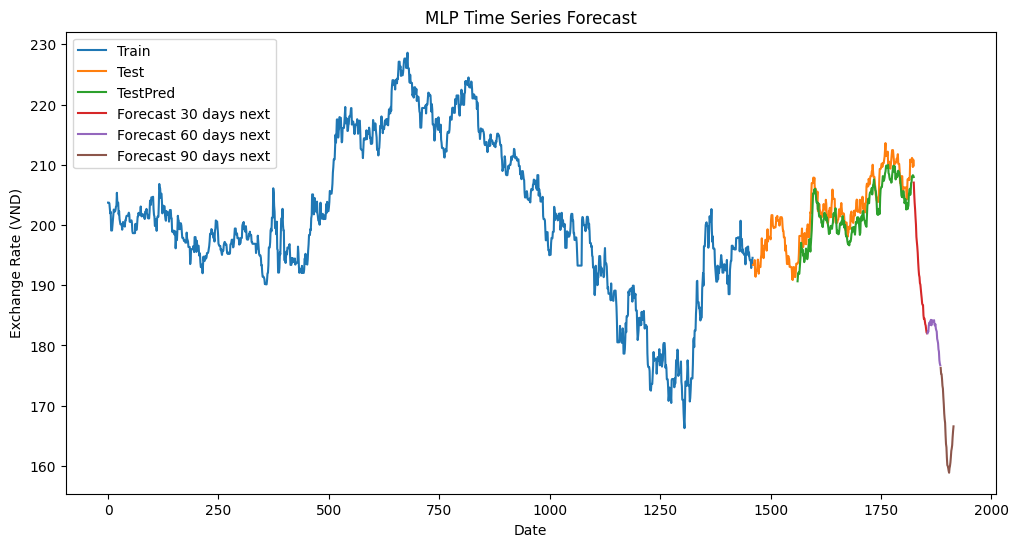

- Test: 
RMSE = 2.8392751511573766
MAPE = 1.174220481649687
MAE = 2.4057666534044473


In [12]:
implement_MLP(train_eur_2_sc, test_eur_2_sc)

- **Case 3. 9:1**

C:\Users\TTMC\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
[0.7154398]
101
1 day input [0.67132991 0.67132991 0.67132991 0.68408004 0.68284045 0.70161148
 0.68142376 0.66920489 0.66920489 0.66920489 0.65078803 0.64087126
 0.62156897 0.61607933 0.60651673 0.60651673 0.60651673 0.60208961
 0.61572516 0.61962104 0.66495484 0.69045511 0.69045511 0.69045511
 0.69328847 0.70391358 0.70462192 0.69612183 0.70586152 0.70586152
 0.70586152 0.7156012  0.72321587 0.74340358 0.75934124 0.72534089
 0.72534089 0.72534089 0.72675757 0.73649726 0.70426775 0.7108199
 0.69488224 0.69488224 0.69488224 0.69116345 0.70019479 0.71471578
 0.7311847  0.74057021 0.74057021 0.74057021 0.72604923 0.71383035
 0.7012573  0.70798654 0.7072782  0.7072782  0.7072782  0.71737206
 0.71648663 0.72073667 0.72976802 0.70391358 0.70391358 0.70391358
 0.68691341 0.65344431 0.66477776 0.64582964 0.67115282 0.67115282
 0.67115282 0.62652736 0.61590225 0.63591287 0.6415796  0.63998583
 0.63998583 0.63998583 0.64140251 0.6367983  0.60917301 0.627058

8 day output [[0.72630477]]
9 day input [0.66920489 0.66920489 0.65078803 0.64087126 0.62156897 0.61607933
 0.60651673 0.60651673 0.60651673 0.60208961 0.61572516 0.61962104
 0.66495484 0.69045511 0.69045511 0.69045511 0.69328847 0.70391358
 0.70462192 0.69612183 0.70586152 0.70586152 0.70586152 0.7156012
 0.72321587 0.74340358 0.75934124 0.72534089 0.72534089 0.72534089
 0.72675757 0.73649726 0.70426775 0.7108199  0.69488224 0.69488224
 0.69488224 0.69116345 0.70019479 0.71471578 0.7311847  0.74057021
 0.74057021 0.74057021 0.72604923 0.71383035 0.7012573  0.70798654
 0.7072782  0.7072782  0.7072782  0.71737206 0.71648663 0.72073667
 0.72976802 0.70391358 0.70391358 0.70391358 0.68691341 0.65344431
 0.66477776 0.64582964 0.67115282 0.67115282 0.67115282 0.62652736
 0.61590225 0.63591287 0.6415796  0.63998583 0.63998583 0.63998583
 0.64140251 0.6367983  0.60917301 0.62705862 0.66265274 0.66265274
 0.66265274 0.66584027 0.6607048  0.66973614 0.71524703 0.70940322
 0.70940322 0.70940322 

18 day output [[0.7503912]]
19 day input [0.61572516 0.61962104 0.66495484 0.69045511 0.69045511 0.69045511
 0.69328847 0.70391358 0.70462192 0.69612183 0.70586152 0.70586152
 0.70586152 0.7156012  0.72321587 0.74340358 0.75934124 0.72534089
 0.72534089 0.72534089 0.72675757 0.73649726 0.70426775 0.7108199
 0.69488224 0.69488224 0.69488224 0.69116345 0.70019479 0.71471578
 0.7311847  0.74057021 0.74057021 0.74057021 0.72604923 0.71383035
 0.7012573  0.70798654 0.7072782  0.7072782  0.7072782  0.71737206
 0.71648663 0.72073667 0.72976802 0.70391358 0.70391358 0.70391358
 0.68691341 0.65344431 0.66477776 0.64582964 0.67115282 0.67115282
 0.67115282 0.62652736 0.61590225 0.63591287 0.6415796  0.63998583
 0.63998583 0.63998583 0.64140251 0.6367983  0.60917301 0.62705862
 0.66265274 0.66265274 0.66265274 0.66584027 0.6607048  0.66973614
 0.71524703 0.70940322 0.70940322 0.70940322 0.71985125 0.7168408
 0.69559058 0.71489286 0.69966354 0.7154398  0.71046162 0.71057773
 0.71878058 0.72515649 

26 day output [[0.77935153]]
27 day input [0.70462192 0.69612183 0.70586152 0.70586152 0.70586152 0.7156012
 0.72321587 0.74340358 0.75934124 0.72534089 0.72534089 0.72534089
 0.72675757 0.73649726 0.70426775 0.7108199  0.69488224 0.69488224
 0.69488224 0.69116345 0.70019479 0.71471578 0.7311847  0.74057021
 0.74057021 0.74057021 0.72604923 0.71383035 0.7012573  0.70798654
 0.7072782  0.7072782  0.7072782  0.71737206 0.71648663 0.72073667
 0.72976802 0.70391358 0.70391358 0.70391358 0.68691341 0.65344431
 0.66477776 0.64582964 0.67115282 0.67115282 0.67115282 0.62652736
 0.61590225 0.63591287 0.6415796  0.63998583 0.63998583 0.63998583
 0.64140251 0.6367983  0.60917301 0.62705862 0.66265274 0.66265274
 0.66265274 0.66584027 0.6607048  0.66973614 0.71524703 0.70940322
 0.70940322 0.70940322 0.71985125 0.7168408  0.69559058 0.71489286
 0.69966354 0.7154398  0.71046162 0.71057773 0.71878058 0.72515649
 0.73163992 0.72011787 0.73040038 0.72630477 0.7262404  0.74201483
 0.73522717 0.7368113

34 day output [[0.8081321]]
35 day input [0.75934124 0.72534089 0.72534089 0.72534089 0.72675757 0.73649726
 0.70426775 0.7108199  0.69488224 0.69488224 0.69488224 0.69116345
 0.70019479 0.71471578 0.7311847  0.74057021 0.74057021 0.74057021
 0.72604923 0.71383035 0.7012573  0.70798654 0.7072782  0.7072782
 0.7072782  0.71737206 0.71648663 0.72073667 0.72976802 0.70391358
 0.70391358 0.70391358 0.68691341 0.65344431 0.66477776 0.64582964
 0.67115282 0.67115282 0.67115282 0.62652736 0.61590225 0.63591287
 0.6415796  0.63998583 0.63998583 0.63998583 0.64140251 0.6367983
 0.60917301 0.62705862 0.66265274 0.66265274 0.66265274 0.66584027
 0.6607048  0.66973614 0.71524703 0.70940322 0.70940322 0.70940322
 0.71985125 0.7168408  0.69559058 0.71489286 0.69966354 0.7154398
 0.71046162 0.71057773 0.71878058 0.72515649 0.73163992 0.72011787
 0.73040038 0.72630477 0.7262404  0.74201483 0.73522717 0.73681134
 0.73866171 0.74847645 0.74312204 0.76635712 0.76104468 0.75039119
 0.7525627  0.75905305 0

42 day output [[0.82425046]]
43 day input [0.69488224 0.69488224 0.69488224 0.69116345 0.70019479 0.71471578
 0.7311847  0.74057021 0.74057021 0.74057021 0.72604923 0.71383035
 0.7012573  0.70798654 0.7072782  0.7072782  0.7072782  0.71737206
 0.71648663 0.72073667 0.72976802 0.70391358 0.70391358 0.70391358
 0.68691341 0.65344431 0.66477776 0.64582964 0.67115282 0.67115282
 0.67115282 0.62652736 0.61590225 0.63591287 0.6415796  0.63998583
 0.63998583 0.63998583 0.64140251 0.6367983  0.60917301 0.62705862
 0.66265274 0.66265274 0.66265274 0.66584027 0.6607048  0.66973614
 0.71524703 0.70940322 0.70940322 0.70940322 0.71985125 0.7168408
 0.69559058 0.71489286 0.69966354 0.7154398  0.71046162 0.71057773
 0.71878058 0.72515649 0.73163992 0.72011787 0.73040038 0.72630477
 0.7262404  0.74201483 0.73522717 0.73681134 0.73866171 0.74847645
 0.74312204 0.76635712 0.76104468 0.75039119 0.7525627  0.75905305
 0.76412898 0.76250565 0.76835054 0.76260507 0.77293271 0.77935153
 0.7904762  0.7853414

51 day output [[0.83478576]]
52 day input [0.74057021 0.72604923 0.71383035 0.7012573  0.70798654 0.7072782
 0.7072782  0.7072782  0.71737206 0.71648663 0.72073667 0.72976802
 0.70391358 0.70391358 0.70391358 0.68691341 0.65344431 0.66477776
 0.64582964 0.67115282 0.67115282 0.67115282 0.62652736 0.61590225
 0.63591287 0.6415796  0.63998583 0.63998583 0.63998583 0.64140251
 0.6367983  0.60917301 0.62705862 0.66265274 0.66265274 0.66265274
 0.66584027 0.6607048  0.66973614 0.71524703 0.70940322 0.70940322
 0.70940322 0.71985125 0.7168408  0.69559058 0.71489286 0.69966354
 0.7154398  0.71046162 0.71057773 0.71878058 0.72515649 0.73163992
 0.72011787 0.73040038 0.72630477 0.7262404  0.74201483 0.73522717
 0.73681134 0.73866171 0.74847645 0.74312204 0.76635712 0.76104468
 0.75039119 0.7525627  0.75905305 0.76412898 0.76250565 0.76835054
 0.76260507 0.77293271 0.77935153 0.7904762  0.78534144 0.78987986
 0.78517902 0.78183073 0.79990017 0.80001509 0.80813211 0.81015986
 0.80476749 0.7933470

61 day output [[0.870969]]
62 day input [0.72073667 0.72976802 0.70391358 0.70391358 0.70391358 0.68691341
 0.65344431 0.66477776 0.64582964 0.67115282 0.67115282 0.67115282
 0.62652736 0.61590225 0.63591287 0.6415796  0.63998583 0.63998583
 0.63998583 0.64140251 0.6367983  0.60917301 0.62705862 0.66265274
 0.66265274 0.66265274 0.66584027 0.6607048  0.66973614 0.71524703
 0.70940322 0.70940322 0.70940322 0.71985125 0.7168408  0.69559058
 0.71489286 0.69966354 0.7154398  0.71046162 0.71057773 0.71878058
 0.72515649 0.73163992 0.72011787 0.73040038 0.72630477 0.7262404
 0.74201483 0.73522717 0.73681134 0.73866171 0.74847645 0.74312204
 0.76635712 0.76104468 0.75039119 0.7525627  0.75905305 0.76412898
 0.76250565 0.76835054 0.76260507 0.77293271 0.77935153 0.7904762
 0.78534144 0.78987986 0.78517902 0.78183073 0.79990017 0.80001509
 0.80813211 0.81015986 0.80476749 0.79334706 0.80524027 0.81974077
 0.80830234 0.82803178 0.82425046 0.8167457  0.81594026 0.83592951
 0.82622266 0.82608354 0

71 day output [[0.89469403]]
72 day input [0.67115282 0.67115282 0.62652736 0.61590225 0.63591287 0.6415796
 0.63998583 0.63998583 0.63998583 0.64140251 0.6367983  0.60917301
 0.62705862 0.66265274 0.66265274 0.66265274 0.66584027 0.6607048
 0.66973614 0.71524703 0.70940322 0.70940322 0.70940322 0.71985125
 0.7168408  0.69559058 0.71489286 0.69966354 0.7154398  0.71046162
 0.71057773 0.71878058 0.72515649 0.73163992 0.72011787 0.73040038
 0.72630477 0.7262404  0.74201483 0.73522717 0.73681134 0.73866171
 0.74847645 0.74312204 0.76635712 0.76104468 0.75039119 0.7525627
 0.75905305 0.76412898 0.76250565 0.76835054 0.76260507 0.77293271
 0.77935153 0.7904762  0.78534144 0.78987986 0.78517902 0.78183073
 0.79990017 0.80001509 0.80813211 0.81015986 0.80476749 0.79334706
 0.80524027 0.81974077 0.80830234 0.82803178 0.82425046 0.8167457
 0.81594026 0.83592951 0.82622266 0.82608354 0.83015138 0.82894653
 0.83281356 0.83478576 0.83848387 0.83291024 0.84678602 0.85981423
 0.85177356 0.85209012 0

81 day output [[0.9320981]]
82 day input [0.6367983  0.60917301 0.62705862 0.66265274 0.66265274 0.66265274
 0.66584027 0.6607048  0.66973614 0.71524703 0.70940322 0.70940322
 0.70940322 0.71985125 0.7168408  0.69559058 0.71489286 0.69966354
 0.7154398  0.71046162 0.71057773 0.71878058 0.72515649 0.73163992
 0.72011787 0.73040038 0.72630477 0.7262404  0.74201483 0.73522717
 0.73681134 0.73866171 0.74847645 0.74312204 0.76635712 0.76104468
 0.75039119 0.7525627  0.75905305 0.76412898 0.76250565 0.76835054
 0.76260507 0.77293271 0.77935153 0.7904762  0.78534144 0.78987986
 0.78517902 0.78183073 0.79990017 0.80001509 0.80813211 0.81015986
 0.80476749 0.79334706 0.80524027 0.81974077 0.80830234 0.82803178
 0.82425046 0.8167457  0.81594026 0.83592951 0.82622266 0.82608354
 0.83015138 0.82894653 0.83281356 0.83478576 0.83848387 0.83291024
 0.84678602 0.85981423 0.85177356 0.85209012 0.85489714 0.85658628
 0.86391193 0.870969   0.85970074 0.87271726 0.87621456 0.87710893
 0.88093084 0.8885930

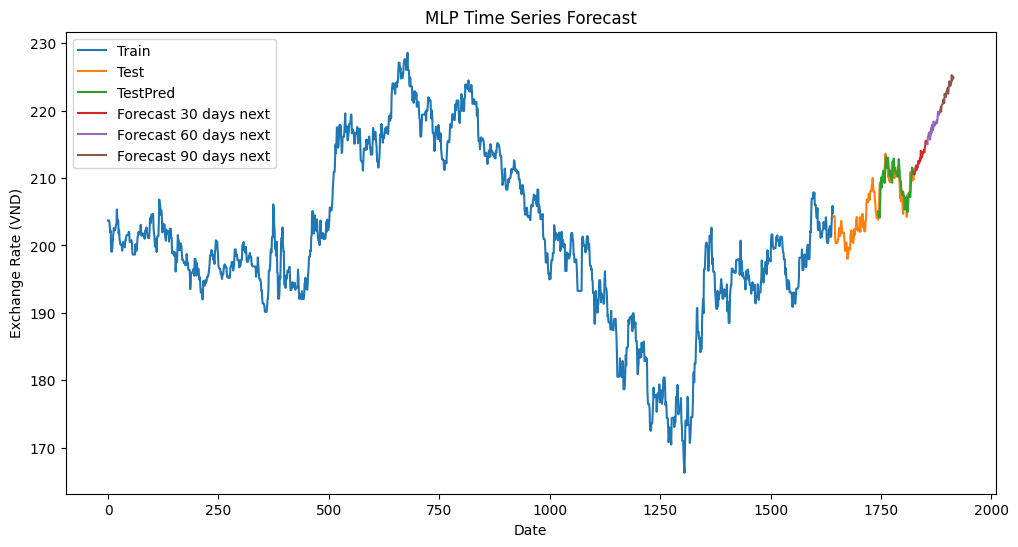

- Test: 
RMSE = 1.651109972510227
MAPE = 0.6143639931726278
MAE = 1.2846392173496701


In [13]:
implement_MLP(train_eur_3_sc, test_eur_3_sc)

# GBP - VND

- **Case 1. 7:3**

C:\Users\TTMC\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
[0.7895607]
101
1 day input [0.71457821 0.71457821 0.71457821 0.73191373 0.73450723 0.75580126
 0.75279825 0.75648376 0.75648376 0.75648376 0.74979525 0.74105924
 0.73027573 0.72167622 0.71048321 0.71048321 0.71048321 0.71116571
 0.71280371 0.70611521 0.74542725 0.78132678 0.78132678 0.78132678
 0.77354627 0.77764128 0.76180726 0.74938575 0.75593776 0.75593776
 0.75593776 0.75880426 0.76822277 0.78200928 0.79183729 0.76535627
 0.76535627 0.76535627 0.76931477 0.78924379 0.75812176 0.78241878
 0.76781327 0.76781327 0.76781327 0.76713077 0.78692329 0.7959323
 0.81094731 0.82350532 0.82350532 0.82350532 0.80644281 0.79429429
 0.78910729 0.8043953  0.8034398  0.8034398  0.8034398  0.80985531
 0.82295932 0.82555283 0.83114933 0.82241332 0.82241332 0.82241332
 0.80835381 0.77231777 0.78269178 0.76835927 0.78883429 0.78883429
 0.78883429 0.75279825 0.72836473 0.76194376 0.76412776 0.76030576
 0.76030576 0.76030576 0.76385476 0.76904177 0.73983074 0.7440

9 day output [[0.72223955]]
10 day input [0.75648376 0.74979525 0.74105924 0.73027573 0.72167622 0.71048321
 0.71048321 0.71048321 0.71116571 0.71280371 0.70611521 0.74542725
 0.78132678 0.78132678 0.78132678 0.77354627 0.77764128 0.76180726
 0.74938575 0.75593776 0.75593776 0.75593776 0.75880426 0.76822277
 0.78200928 0.79183729 0.76535627 0.76535627 0.76535627 0.76931477
 0.78924379 0.75812176 0.78241878 0.76781327 0.76781327 0.76781327
 0.76713077 0.78692329 0.7959323  0.81094731 0.82350532 0.82350532
 0.82350532 0.80644281 0.79429429 0.78910729 0.8043953  0.8034398
 0.8034398  0.8034398  0.80985531 0.82295932 0.82555283 0.83114933
 0.82241332 0.82241332 0.82241332 0.80835381 0.77231777 0.78269178
 0.76835927 0.78883429 0.78883429 0.78883429 0.75279825 0.72836473
 0.76194376 0.76412776 0.76030576 0.76030576 0.76030576 0.76385476
 0.76904177 0.73983074 0.74406224 0.76999727 0.76999727 0.76999727
 0.78228228 0.76972427 0.77559378 0.81927382 0.82022932 0.82022932
 0.82022932 0.82637183

17 day output [[0.6706008]]
18 day input [0.71116571 0.71280371 0.70611521 0.74542725 0.78132678 0.78132678
 0.78132678 0.77354627 0.77764128 0.76180726 0.74938575 0.75593776
 0.75593776 0.75593776 0.75880426 0.76822277 0.78200928 0.79183729
 0.76535627 0.76535627 0.76535627 0.76931477 0.78924379 0.75812176
 0.78241878 0.76781327 0.76781327 0.76781327 0.76713077 0.78692329
 0.7959323  0.81094731 0.82350532 0.82350532 0.82350532 0.80644281
 0.79429429 0.78910729 0.8043953  0.8034398  0.8034398  0.8034398
 0.80985531 0.82295932 0.82555283 0.83114933 0.82241332 0.82241332
 0.82241332 0.80835381 0.77231777 0.78269178 0.76835927 0.78883429
 0.78883429 0.78883429 0.75279825 0.72836473 0.76194376 0.76412776
 0.76030576 0.76030576 0.76030576 0.76385476 0.76904177 0.73983074
 0.74406224 0.76999727 0.76999727 0.76999727 0.78228228 0.76972427
 0.77559378 0.81927382 0.82022932 0.82022932 0.82022932 0.82637183
 0.82159432 0.8030303  0.81572482 0.8030303  0.78956068 0.78394586
 0.77080548 0.76586115

25 day output [[0.6414045]]
26 day input [0.77764128 0.76180726 0.74938575 0.75593776 0.75593776 0.75593776
 0.75880426 0.76822277 0.78200928 0.79183729 0.76535627 0.76535627
 0.76535627 0.76931477 0.78924379 0.75812176 0.78241878 0.76781327
 0.76781327 0.76781327 0.76713077 0.78692329 0.7959323  0.81094731
 0.82350532 0.82350532 0.82350532 0.80644281 0.79429429 0.78910729
 0.8043953  0.8034398  0.8034398  0.8034398  0.80985531 0.82295932
 0.82555283 0.83114933 0.82241332 0.82241332 0.82241332 0.80835381
 0.77231777 0.78269178 0.76835927 0.78883429 0.78883429 0.78883429
 0.75279825 0.72836473 0.76194376 0.76412776 0.76030576 0.76030576
 0.76030576 0.76385476 0.76904177 0.73983074 0.74406224 0.76999727
 0.76999727 0.76999727 0.78228228 0.76972427 0.77559378 0.81927382
 0.82022932 0.82022932 0.82022932 0.82637183 0.82159432 0.8030303
 0.81572482 0.8030303  0.78956068 0.78394586 0.77080548 0.76586115
 0.75626838 0.74335229 0.74010152 0.73244303 0.72962886 0.72223955
 0.72179741 0.71986091

33 day output [[0.6144492]]
34 day input [0.78200928 0.79183729 0.76535627 0.76535627 0.76535627 0.76931477
 0.78924379 0.75812176 0.78241878 0.76781327 0.76781327 0.76781327
 0.76713077 0.78692329 0.7959323  0.81094731 0.82350532 0.82350532
 0.82350532 0.80644281 0.79429429 0.78910729 0.8043953  0.8034398
 0.8034398  0.8034398  0.80985531 0.82295932 0.82555283 0.83114933
 0.82241332 0.82241332 0.82241332 0.80835381 0.77231777 0.78269178
 0.76835927 0.78883429 0.78883429 0.78883429 0.75279825 0.72836473
 0.76194376 0.76412776 0.76030576 0.76030576 0.76030576 0.76385476
 0.76904177 0.73983074 0.74406224 0.76999727 0.76999727 0.76999727
 0.78228228 0.76972427 0.77559378 0.81927382 0.82022932 0.82022932
 0.82022932 0.82637183 0.82159432 0.8030303  0.81572482 0.8030303
 0.78956068 0.78394586 0.77080548 0.76586115 0.75626838 0.74335229
 0.74010152 0.73244303 0.72962886 0.72223955 0.72179741 0.71986091
 0.70377123 0.69280261 0.69263631 0.69073838 0.67195278 0.67060077
 0.66622001 0.66352022 

41 day output [[0.58294946]]
42 day input [0.78241878 0.76781327 0.76781327 0.76781327 0.76713077 0.78692329
 0.7959323  0.81094731 0.82350532 0.82350532 0.82350532 0.80644281
 0.79429429 0.78910729 0.8043953  0.8034398  0.8034398  0.8034398
 0.80985531 0.82295932 0.82555283 0.83114933 0.82241332 0.82241332
 0.82241332 0.80835381 0.77231777 0.78269178 0.76835927 0.78883429
 0.78883429 0.78883429 0.75279825 0.72836473 0.76194376 0.76412776
 0.76030576 0.76030576 0.76030576 0.76385476 0.76904177 0.73983074
 0.74406224 0.76999727 0.76999727 0.76999727 0.78228228 0.76972427
 0.77559378 0.81927382 0.82022932 0.82022932 0.82022932 0.82637183
 0.82159432 0.8030303  0.81572482 0.8030303  0.78956068 0.78394586
 0.77080548 0.76586115 0.75626838 0.74335229 0.74010152 0.73244303
 0.72962886 0.72223955 0.72179741 0.71986091 0.70377123 0.69280261
 0.69263631 0.69073838 0.67195278 0.67060077 0.66622001 0.66352022
 0.64544964 0.64529556 0.6441766  0.64486122 0.65234601 0.64140451
 0.63159901 0.6177947

49 day output [[0.5602677]]
50 day input [0.82350532 0.82350532 0.82350532 0.80644281 0.79429429 0.78910729
 0.8043953  0.8034398  0.8034398  0.8034398  0.80985531 0.82295932
 0.82555283 0.83114933 0.82241332 0.82241332 0.82241332 0.80835381
 0.77231777 0.78269178 0.76835927 0.78883429 0.78883429 0.78883429
 0.75279825 0.72836473 0.76194376 0.76412776 0.76030576 0.76030576
 0.76030576 0.76385476 0.76904177 0.73983074 0.74406224 0.76999727
 0.76999727 0.76999727 0.78228228 0.76972427 0.77559378 0.81927382
 0.82022932 0.82022932 0.82022932 0.82637183 0.82159432 0.8030303
 0.81572482 0.8030303  0.78956068 0.78394586 0.77080548 0.76586115
 0.75626838 0.74335229 0.74010152 0.73244303 0.72962886 0.72223955
 0.72179741 0.71986091 0.70377123 0.69280261 0.69263631 0.69073838
 0.67195278 0.67060077 0.66622001 0.66352022 0.64544964 0.64529556
 0.6441766  0.64486122 0.65234601 0.64140451 0.63159901 0.61779475
 0.62513638 0.61916107 0.61200976 0.59568012 0.60393685 0.6144492
 0.6060251  0.60736978 

57 day output [[0.54382014]]
58 day input [0.8034398  0.8034398  0.80985531 0.82295932 0.82555283 0.83114933
 0.82241332 0.82241332 0.82241332 0.80835381 0.77231777 0.78269178
 0.76835927 0.78883429 0.78883429 0.78883429 0.75279825 0.72836473
 0.76194376 0.76412776 0.76030576 0.76030576 0.76030576 0.76385476
 0.76904177 0.73983074 0.74406224 0.76999727 0.76999727 0.76999727
 0.78228228 0.76972427 0.77559378 0.81927382 0.82022932 0.82022932
 0.82022932 0.82637183 0.82159432 0.8030303  0.81572482 0.8030303
 0.78956068 0.78394586 0.77080548 0.76586115 0.75626838 0.74335229
 0.74010152 0.73244303 0.72962886 0.72223955 0.72179741 0.71986091
 0.70377123 0.69280261 0.69263631 0.69073838 0.67195278 0.67060077
 0.66622001 0.66352022 0.64544964 0.64529556 0.6441766  0.64486122
 0.65234601 0.64140451 0.63159901 0.61779475 0.62513638 0.61916107
 0.61200976 0.59568012 0.60393685 0.6144492  0.6060251  0.60736978
 0.60078955 0.59657389 0.58620059 0.58697301 0.58336401 0.58294946
 0.57734931 0.5794178

65 day output [[0.5004908]]
66 day input [0.82241332 0.80835381 0.77231777 0.78269178 0.76835927 0.78883429
 0.78883429 0.78883429 0.75279825 0.72836473 0.76194376 0.76412776
 0.76030576 0.76030576 0.76030576 0.76385476 0.76904177 0.73983074
 0.74406224 0.76999727 0.76999727 0.76999727 0.78228228 0.76972427
 0.77559378 0.81927382 0.82022932 0.82022932 0.82022932 0.82637183
 0.82159432 0.8030303  0.81572482 0.8030303  0.78956068 0.78394586
 0.77080548 0.76586115 0.75626838 0.74335229 0.74010152 0.73244303
 0.72962886 0.72223955 0.72179741 0.71986091 0.70377123 0.69280261
 0.69263631 0.69073838 0.67195278 0.67060077 0.66622001 0.66352022
 0.64544964 0.64529556 0.6441766  0.64486122 0.65234601 0.64140451
 0.63159901 0.61779475 0.62513638 0.61916107 0.61200976 0.59568012
 0.60393685 0.6144492  0.6060251  0.60736978 0.60078955 0.59657389
 0.58620059 0.58697301 0.58336401 0.58294946 0.57734931 0.57941782
 0.58057129 0.56666619 0.56586742 0.5669027  0.57040173 0.56026769
 0.56483221 0.5591826

75 day output [[0.47775465]]
76 day input [0.76194376 0.76412776 0.76030576 0.76030576 0.76030576 0.76385476
 0.76904177 0.73983074 0.74406224 0.76999727 0.76999727 0.76999727
 0.78228228 0.76972427 0.77559378 0.81927382 0.82022932 0.82022932
 0.82022932 0.82637183 0.82159432 0.8030303  0.81572482 0.8030303
 0.78956068 0.78394586 0.77080548 0.76586115 0.75626838 0.74335229
 0.74010152 0.73244303 0.72962886 0.72223955 0.72179741 0.71986091
 0.70377123 0.69280261 0.69263631 0.69073838 0.67195278 0.67060077
 0.66622001 0.66352022 0.64544964 0.64529556 0.6441766  0.64486122
 0.65234601 0.64140451 0.63159901 0.61779475 0.62513638 0.61916107
 0.61200976 0.59568012 0.60393685 0.6144492  0.6060251  0.60736978
 0.60078955 0.59657389 0.58620059 0.58697301 0.58336401 0.58294946
 0.57734931 0.57941782 0.58057129 0.56666619 0.56586742 0.5669027
 0.57040173 0.56026769 0.56483221 0.55918264 0.5594666  0.55462223
 0.55393016 0.5537321  0.54255646 0.54382014 0.53097385 0.52588016
 0.51019239 0.5165537 

83 day output [[0.4668874]]
84 day input [0.74406224 0.76999727 0.76999727 0.76999727 0.78228228 0.76972427
 0.77559378 0.81927382 0.82022932 0.82022932 0.82022932 0.82637183
 0.82159432 0.8030303  0.81572482 0.8030303  0.78956068 0.78394586
 0.77080548 0.76586115 0.75626838 0.74335229 0.74010152 0.73244303
 0.72962886 0.72223955 0.72179741 0.71986091 0.70377123 0.69280261
 0.69263631 0.69073838 0.67195278 0.67060077 0.66622001 0.66352022
 0.64544964 0.64529556 0.6441766  0.64486122 0.65234601 0.64140451
 0.63159901 0.61779475 0.62513638 0.61916107 0.61200976 0.59568012
 0.60393685 0.6144492  0.6060251  0.60736978 0.60078955 0.59657389
 0.58620059 0.58697301 0.58336401 0.58294946 0.57734931 0.57941782
 0.58057129 0.56666619 0.56586742 0.5669027  0.57040173 0.56026769
 0.56483221 0.55918264 0.5594666  0.55462223 0.55393016 0.5537321
 0.54255646 0.54382014 0.53097385 0.52588016 0.51019239 0.5165537
 0.51769871 0.51507753 0.50196934 0.50049078 0.50647682 0.49981067
 0.48360771 0.48458475 

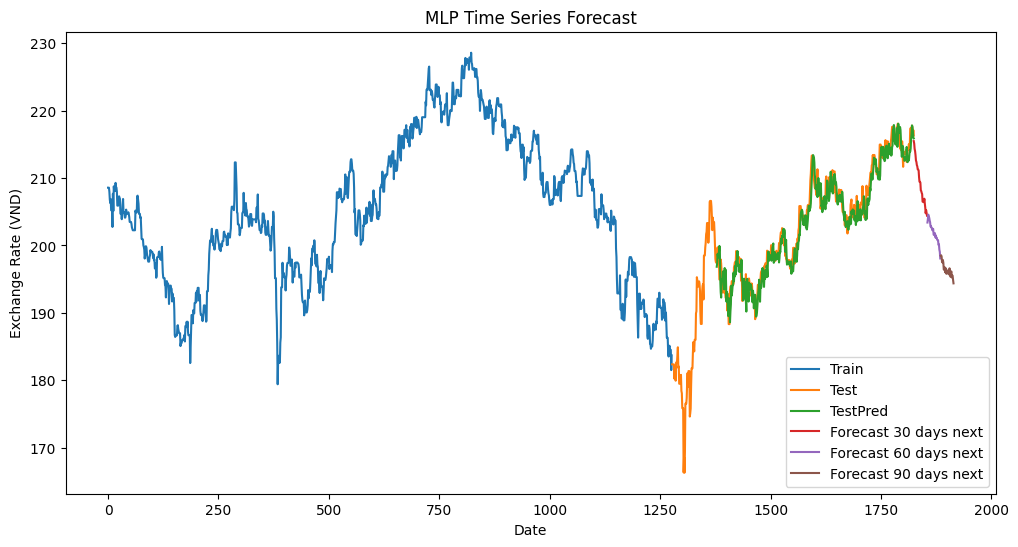

- Test: 
RMSE = 1.7918714379330296
MAPE = 0.6863585824989215
MAE = 1.3982973232069527


In [14]:
implement_MLP(train_gbp_1_sc, test_gbp_1_sc)

- **Case 2. 8:2**

C:\Users\TTMC\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
[0.81346244]
101
1 day input [0.71457821 0.71457821 0.71457821 0.73191373 0.73450723 0.75580126
 0.75279825 0.75648376 0.75648376 0.75648376 0.74979525 0.74105924
 0.73027573 0.72167622 0.71048321 0.71048321 0.71048321 0.71116571
 0.71280371 0.70611521 0.74542725 0.78132678 0.78132678 0.78132678
 0.77354627 0.77764128 0.76180726 0.74938575 0.75593776 0.75593776
 0.75593776 0.75880426 0.76822277 0.78200928 0.79183729 0.76535627
 0.76535627 0.76535627 0.76931477 0.78924379 0.75812176 0.78241878
 0.76781327 0.76781327 0.76781327 0.76713077 0.78692329 0.7959323
 0.81094731 0.82350532 0.82350532 0.82350532 0.80644281 0.79429429
 0.78910729 0.8043953  0.8034398  0.8034398  0.8034398  0.80985531
 0.82295932 0.82555283 0.83114933 0.82241332 0.82241332 0.82241332
 0.80835381 0.77231777 0.78269178 0.76835927 0.78883429 0.78883429
 0.78883429 0.75279825 0.72836473 0.76194376 0.76412776 0.76030576
 0.76030576 0.76030576 0.76385476 0.76904177 0.73983074 0.74406

8 day output [[0.7915068]]
9 day input [0.75648376 0.75648376 0.74979525 0.74105924 0.73027573 0.72167622
 0.71048321 0.71048321 0.71048321 0.71116571 0.71280371 0.70611521
 0.74542725 0.78132678 0.78132678 0.78132678 0.77354627 0.77764128
 0.76180726 0.74938575 0.75593776 0.75593776 0.75593776 0.75880426
 0.76822277 0.78200928 0.79183729 0.76535627 0.76535627 0.76535627
 0.76931477 0.78924379 0.75812176 0.78241878 0.76781327 0.76781327
 0.76781327 0.76713077 0.78692329 0.7959323  0.81094731 0.82350532
 0.82350532 0.82350532 0.80644281 0.79429429 0.78910729 0.8043953
 0.8034398  0.8034398  0.8034398  0.80985531 0.82295932 0.82555283
 0.83114933 0.82241332 0.82241332 0.82241332 0.80835381 0.77231777
 0.78269178 0.76835927 0.78883429 0.78883429 0.78883429 0.75279825
 0.72836473 0.76194376 0.76412776 0.76030576 0.76030576 0.76030576
 0.76385476 0.76904177 0.73983074 0.74406224 0.76999727 0.76999727
 0.76999727 0.78228228 0.76972427 0.77559378 0.81927382 0.82022932
 0.82022932 0.82022932 0

18 day output [[0.78511643]]
19 day input [0.71280371 0.70611521 0.74542725 0.78132678 0.78132678 0.78132678
 0.77354627 0.77764128 0.76180726 0.74938575 0.75593776 0.75593776
 0.75593776 0.75880426 0.76822277 0.78200928 0.79183729 0.76535627
 0.76535627 0.76535627 0.76931477 0.78924379 0.75812176 0.78241878
 0.76781327 0.76781327 0.76781327 0.76713077 0.78692329 0.7959323
 0.81094731 0.82350532 0.82350532 0.82350532 0.80644281 0.79429429
 0.78910729 0.8043953  0.8034398  0.8034398  0.8034398  0.80985531
 0.82295932 0.82555283 0.83114933 0.82241332 0.82241332 0.82241332
 0.80835381 0.77231777 0.78269178 0.76835927 0.78883429 0.78883429
 0.78883429 0.75279825 0.72836473 0.76194376 0.76412776 0.76030576
 0.76030576 0.76030576 0.76385476 0.76904177 0.73983074 0.74406224
 0.76999727 0.76999727 0.76999727 0.78228228 0.76972427 0.77559378
 0.81927382 0.82022932 0.82022932 0.82022932 0.82637183 0.82159432
 0.8030303  0.81572482 0.8030303  0.81346244 0.80951083 0.79331851
 0.80495876 0.8020777

28 day output [[0.76268554]]
29 day input [0.75593776 0.75593776 0.75593776 0.75880426 0.76822277 0.78200928
 0.79183729 0.76535627 0.76535627 0.76535627 0.76931477 0.78924379
 0.75812176 0.78241878 0.76781327 0.76781327 0.76781327 0.76713077
 0.78692329 0.7959323  0.81094731 0.82350532 0.82350532 0.82350532
 0.80644281 0.79429429 0.78910729 0.8043953  0.8034398  0.8034398
 0.8034398  0.80985531 0.82295932 0.82555283 0.83114933 0.82241332
 0.82241332 0.82241332 0.80835381 0.77231777 0.78269178 0.76835927
 0.78883429 0.78883429 0.78883429 0.75279825 0.72836473 0.76194376
 0.76412776 0.76030576 0.76030576 0.76030576 0.76385476 0.76904177
 0.73983074 0.74406224 0.76999727 0.76999727 0.76999727 0.78228228
 0.76972427 0.77559378 0.81927382 0.82022932 0.82022932 0.82022932
 0.82637183 0.82159432 0.8030303  0.81572482 0.8030303  0.81346244
 0.80951083 0.79331851 0.80495876 0.80207771 0.78419262 0.78368396
 0.78068852 0.79150683 0.7995683  0.80295175 0.79822993 0.78022718
 0.78938663 0.7942986

36 day output [[0.7456087]]
37 day input [0.76535627 0.76535627 0.76931477 0.78924379 0.75812176 0.78241878
 0.76781327 0.76781327 0.76781327 0.76713077 0.78692329 0.7959323
 0.81094731 0.82350532 0.82350532 0.82350532 0.80644281 0.79429429
 0.78910729 0.8043953  0.8034398  0.8034398  0.8034398  0.80985531
 0.82295932 0.82555283 0.83114933 0.82241332 0.82241332 0.82241332
 0.80835381 0.77231777 0.78269178 0.76835927 0.78883429 0.78883429
 0.78883429 0.75279825 0.72836473 0.76194376 0.76412776 0.76030576
 0.76030576 0.76030576 0.76385476 0.76904177 0.73983074 0.74406224
 0.76999727 0.76999727 0.76999727 0.78228228 0.76972427 0.77559378
 0.81927382 0.82022932 0.82022932 0.82022932 0.82637183 0.82159432
 0.8030303  0.81572482 0.8030303  0.81346244 0.80951083 0.79331851
 0.80495876 0.80207771 0.78419262 0.78368396 0.78068852 0.79150683
 0.7995683  0.80295175 0.79822993 0.78022718 0.78938663 0.79429865
 0.79094237 0.79105747 0.78100795 0.78511643 0.78859907 0.7839154
 0.77499253 0.7639218  

45 day output [[0.737738]]
46 day input [0.76713077 0.78692329 0.7959323  0.81094731 0.82350532 0.82350532
 0.82350532 0.80644281 0.79429429 0.78910729 0.8043953  0.8034398
 0.8034398  0.8034398  0.80985531 0.82295932 0.82555283 0.83114933
 0.82241332 0.82241332 0.82241332 0.80835381 0.77231777 0.78269178
 0.76835927 0.78883429 0.78883429 0.78883429 0.75279825 0.72836473
 0.76194376 0.76412776 0.76030576 0.76030576 0.76030576 0.76385476
 0.76904177 0.73983074 0.74406224 0.76999727 0.76999727 0.76999727
 0.78228228 0.76972427 0.77559378 0.81927382 0.82022932 0.82022932
 0.82022932 0.82637183 0.82159432 0.8030303  0.81572482 0.8030303
 0.81346244 0.80951083 0.79331851 0.80495876 0.80207771 0.78419262
 0.78368396 0.78068852 0.79150683 0.7995683  0.80295175 0.79822993
 0.78022718 0.78938663 0.79429865 0.79094237 0.79105747 0.78100795
 0.78511643 0.78859907 0.7839154  0.77499253 0.7639218  0.76952183
 0.77297026 0.78770775 0.78098649 0.77158815 0.76268554 0.75740582
 0.76412696 0.76397914 0

55 day output [[0.73926854]]
56 day input [0.8043953  0.8034398  0.8034398  0.8034398  0.80985531 0.82295932
 0.82555283 0.83114933 0.82241332 0.82241332 0.82241332 0.80835381
 0.77231777 0.78269178 0.76835927 0.78883429 0.78883429 0.78883429
 0.75279825 0.72836473 0.76194376 0.76412776 0.76030576 0.76030576
 0.76030576 0.76385476 0.76904177 0.73983074 0.74406224 0.76999727
 0.76999727 0.76999727 0.78228228 0.76972427 0.77559378 0.81927382
 0.82022932 0.82022932 0.82022932 0.82637183 0.82159432 0.8030303
 0.81572482 0.8030303  0.81346244 0.80951083 0.79331851 0.80495876
 0.80207771 0.78419262 0.78368396 0.78068852 0.79150683 0.7995683
 0.80295175 0.79822993 0.78022718 0.78938663 0.79429865 0.79094237
 0.79105747 0.78100795 0.78511643 0.78859907 0.7839154  0.77499253
 0.7639218  0.76952183 0.77297026 0.78770775 0.78098649 0.77158815
 0.76268554 0.75740582 0.76412696 0.76397914 0.75648499 0.7566756
 0.76112211 0.75746667 0.74560869 0.74809545 0.74620712 0.75518107
 0.75835246 0.76170319 

65 day output [[0.6971627]]
66 day input [0.82241332 0.80835381 0.77231777 0.78269178 0.76835927 0.78883429
 0.78883429 0.78883429 0.75279825 0.72836473 0.76194376 0.76412776
 0.76030576 0.76030576 0.76030576 0.76385476 0.76904177 0.73983074
 0.74406224 0.76999727 0.76999727 0.76999727 0.78228228 0.76972427
 0.77559378 0.81927382 0.82022932 0.82022932 0.82022932 0.82637183
 0.82159432 0.8030303  0.81572482 0.8030303  0.81346244 0.80951083
 0.79331851 0.80495876 0.80207771 0.78419262 0.78368396 0.78068852
 0.79150683 0.7995683  0.80295175 0.79822993 0.78022718 0.78938663
 0.79429865 0.79094237 0.79105747 0.78100795 0.78511643 0.78859907
 0.7839154  0.77499253 0.7639218  0.76952183 0.77297026 0.78770775
 0.78098649 0.77158815 0.76268554 0.75740582 0.76412696 0.76397914
 0.75648499 0.7566756  0.76112211 0.75746667 0.74560869 0.74809545
 0.74620712 0.75518107 0.75835246 0.76170319 0.7488907  0.73576212
 0.72576499 0.73773801 0.75279963 0.74745691 0.74795586 0.73883402
 0.73324466 0.7364197

76 day output [[0.6771432]]
77 day input [0.76412776 0.76030576 0.76030576 0.76030576 0.76385476 0.76904177
 0.73983074 0.74406224 0.76999727 0.76999727 0.76999727 0.78228228
 0.76972427 0.77559378 0.81927382 0.82022932 0.82022932 0.82022932
 0.82637183 0.82159432 0.8030303  0.81572482 0.8030303  0.81346244
 0.80951083 0.79331851 0.80495876 0.80207771 0.78419262 0.78368396
 0.78068852 0.79150683 0.7995683  0.80295175 0.79822993 0.78022718
 0.78938663 0.79429865 0.79094237 0.79105747 0.78100795 0.78511643
 0.78859907 0.7839154  0.77499253 0.7639218  0.76952183 0.77297026
 0.78770775 0.78098649 0.77158815 0.76268554 0.75740582 0.76412696
 0.76397914 0.75648499 0.7566756  0.76112211 0.75746667 0.74560869
 0.74809545 0.74620712 0.75518107 0.75835246 0.76170319 0.7488907
 0.73576212 0.72576499 0.73773801 0.75279963 0.74745691 0.74795586
 0.73883402 0.73324466 0.73641974 0.74392849 0.74016672 0.73522884
 0.73926854 0.73946095 0.73218501 0.72306257 0.71640903 0.71346766
 0.71881235 0.71883512

87 day output [[0.6614552]]
88 day input [0.78228228 0.76972427 0.77559378 0.81927382 0.82022932 0.82022932
 0.82022932 0.82637183 0.82159432 0.8030303  0.81572482 0.8030303
 0.81346244 0.80951083 0.79331851 0.80495876 0.80207771 0.78419262
 0.78368396 0.78068852 0.79150683 0.7995683  0.80295175 0.79822993
 0.78022718 0.78938663 0.79429865 0.79094237 0.79105747 0.78100795
 0.78511643 0.78859907 0.7839154  0.77499253 0.7639218  0.76952183
 0.77297026 0.78770775 0.78098649 0.77158815 0.76268554 0.75740582
 0.76412696 0.76397914 0.75648499 0.7566756  0.76112211 0.75746667
 0.74560869 0.74809545 0.74620712 0.75518107 0.75835246 0.76170319
 0.7488907  0.73576212 0.72576499 0.73773801 0.75279963 0.74745691
 0.74795586 0.73883402 0.73324466 0.73641974 0.74392849 0.74016672
 0.73522884 0.73926854 0.73946095 0.73218501 0.72306257 0.71640903
 0.71346766 0.71881235 0.71883512 0.71458995 0.71251512 0.69716269
 0.69674188 0.69999182 0.69992816 0.69610804 0.6929583  0.68466115
 0.68695635 0.69686019

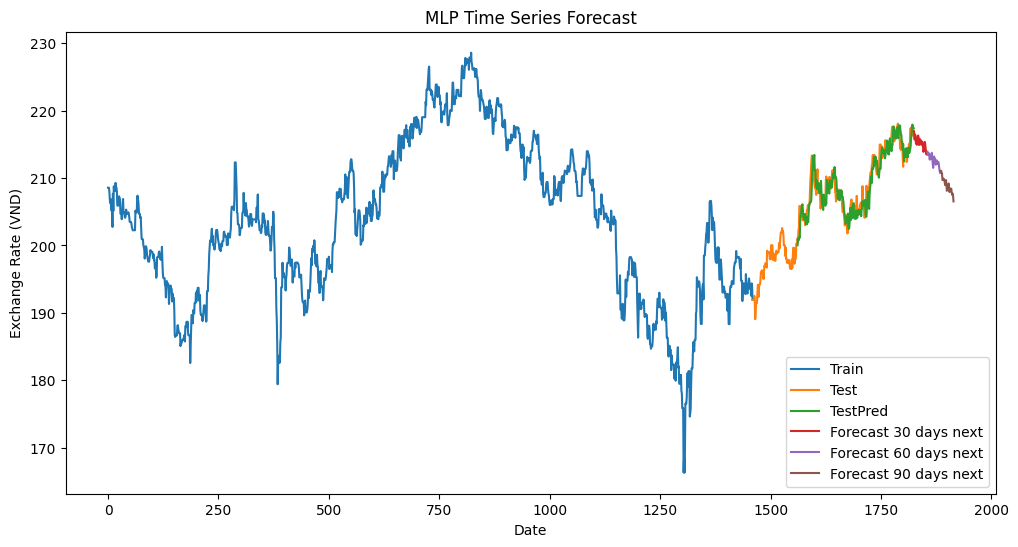

- Test: 
RMSE = 1.678547377207356
MAPE = 0.6228763742384424
MAE = 1.3054614417211845


In [15]:
implement_MLP(train_gbp_2_sc, test_gbp_2_sc)

- **Case 3. 9:1**

C:\Users\TTMC\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
[0.7703807]
101
1 day input [0.71457821 0.71457821 0.71457821 0.73191373 0.73450723 0.75580126
 0.75279825 0.75648376 0.75648376 0.75648376 0.74979525 0.74105924
 0.73027573 0.72167622 0.71048321 0.71048321 0.71048321 0.71116571
 0.71280371 0.70611521 0.74542725 0.78132678 0.78132678 0.78132678
 0.77354627 0.77764128 0.76180726 0.74938575 0.75593776 0.75593776
 0.75593776 0.75880426 0.76822277 0.78200928 0.79183729 0.76535627
 0.76535627 0.76535627 0.76931477 0.78924379 0.75812176 0.78241878
 0.76781327 0.76781327 0.76781327 0.76713077 0.78692329 0.7959323
 0.81094731 0.82350532 0.82350532 0.82350532 0.80644281 0.79429429
 0.78910729 0.8043953  0.8034398  0.8034398  0.8034398  0.80985531
 0.82295932 0.82555283 0.83114933 0.82241332 0.82241332 0.82241332
 0.80835381 0.77231777 0.78269178 0.76835927 0.78883429 0.78883429
 0.78883429 0.75279825 0.72836473 0.76194376 0.76412776 0.76030576
 0.76030576 0.76030576 0.76385476 0.76904177 0.73983074 0.744062

8 day output [[0.6494067]]
9 day input [0.75648376 0.75648376 0.74979525 0.74105924 0.73027573 0.72167622
 0.71048321 0.71048321 0.71048321 0.71116571 0.71280371 0.70611521
 0.74542725 0.78132678 0.78132678 0.78132678 0.77354627 0.77764128
 0.76180726 0.74938575 0.75593776 0.75593776 0.75593776 0.75880426
 0.76822277 0.78200928 0.79183729 0.76535627 0.76535627 0.76535627
 0.76931477 0.78924379 0.75812176 0.78241878 0.76781327 0.76781327
 0.76781327 0.76713077 0.78692329 0.7959323  0.81094731 0.82350532
 0.82350532 0.82350532 0.80644281 0.79429429 0.78910729 0.8043953
 0.8034398  0.8034398  0.8034398  0.80985531 0.82295932 0.82555283
 0.83114933 0.82241332 0.82241332 0.82241332 0.80835381 0.77231777
 0.78269178 0.76835927 0.78883429 0.78883429 0.78883429 0.75279825
 0.72836473 0.76194376 0.76412776 0.76030576 0.76030576 0.76030576
 0.76385476 0.76904177 0.73983074 0.74406224 0.76999727 0.76999727
 0.76999727 0.78228228 0.76972427 0.77559378 0.81927382 0.82022932
 0.82022932 0.82022932 0

17 day output [[0.53093445]]
18 day input [0.71116571 0.71280371 0.70611521 0.74542725 0.78132678 0.78132678
 0.78132678 0.77354627 0.77764128 0.76180726 0.74938575 0.75593776
 0.75593776 0.75593776 0.75880426 0.76822277 0.78200928 0.79183729
 0.76535627 0.76535627 0.76535627 0.76931477 0.78924379 0.75812176
 0.78241878 0.76781327 0.76781327 0.76781327 0.76713077 0.78692329
 0.7959323  0.81094731 0.82350532 0.82350532 0.82350532 0.80644281
 0.79429429 0.78910729 0.8043953  0.8034398  0.8034398  0.8034398
 0.80985531 0.82295932 0.82555283 0.83114933 0.82241332 0.82241332
 0.82241332 0.80835381 0.77231777 0.78269178 0.76835927 0.78883429
 0.78883429 0.78883429 0.75279825 0.72836473 0.76194376 0.76412776
 0.76030576 0.76030576 0.76030576 0.76385476 0.76904177 0.73983074
 0.74406224 0.76999727 0.76999727 0.76999727 0.78228228 0.76972427
 0.77559378 0.81927382 0.82022932 0.82022932 0.82022932 0.82637183
 0.82159432 0.8030303  0.81572482 0.8030303  0.77038068 0.77287763
 0.75275946 0.7156650

26 day output [[0.48236665]]
27 day input [0.76180726 0.74938575 0.75593776 0.75593776 0.75593776 0.75880426
 0.76822277 0.78200928 0.79183729 0.76535627 0.76535627 0.76535627
 0.76931477 0.78924379 0.75812176 0.78241878 0.76781327 0.76781327
 0.76781327 0.76713077 0.78692329 0.7959323  0.81094731 0.82350532
 0.82350532 0.82350532 0.80644281 0.79429429 0.78910729 0.8043953
 0.8034398  0.8034398  0.8034398  0.80985531 0.82295932 0.82555283
 0.83114933 0.82241332 0.82241332 0.82241332 0.80835381 0.77231777
 0.78269178 0.76835927 0.78883429 0.78883429 0.78883429 0.75279825
 0.72836473 0.76194376 0.76412776 0.76030576 0.76030576 0.76030576
 0.76385476 0.76904177 0.73983074 0.74406224 0.76999727 0.76999727
 0.76999727 0.78228228 0.76972427 0.77559378 0.81927382 0.82022932
 0.82022932 0.82022932 0.82637183 0.82159432 0.8030303  0.81572482
 0.8030303  0.77038068 0.77287763 0.75275946 0.71566504 0.69941682
 0.6917181  0.69162691 0.67094207 0.64940667 0.63823742 0.62004423
 0.6077798  0.5971095

34 day output [[0.48170263]]
35 day input [0.79183729 0.76535627 0.76535627 0.76535627 0.76931477 0.78924379
 0.75812176 0.78241878 0.76781327 0.76781327 0.76781327 0.76713077
 0.78692329 0.7959323  0.81094731 0.82350532 0.82350532 0.82350532
 0.80644281 0.79429429 0.78910729 0.8043953  0.8034398  0.8034398
 0.8034398  0.80985531 0.82295932 0.82555283 0.83114933 0.82241332
 0.82241332 0.82241332 0.80835381 0.77231777 0.78269178 0.76835927
 0.78883429 0.78883429 0.78883429 0.75279825 0.72836473 0.76194376
 0.76412776 0.76030576 0.76030576 0.76030576 0.76385476 0.76904177
 0.73983074 0.74406224 0.76999727 0.76999727 0.76999727 0.78228228
 0.76972427 0.77559378 0.81927382 0.82022932 0.82022932 0.82022932
 0.82637183 0.82159432 0.8030303  0.81572482 0.8030303  0.77038068
 0.77287763 0.75275946 0.71566504 0.69941682 0.6917181  0.69162691
 0.67094207 0.64940667 0.63823742 0.62004423 0.6077798  0.5971095
 0.57510906 0.56904685 0.56193149 0.55078691 0.53093445 0.52478409
 0.51747656 0.50805515

43 day output [[0.4402307]]
44 day input [0.76781327 0.76781327 0.76713077 0.78692329 0.7959323  0.81094731
 0.82350532 0.82350532 0.82350532 0.80644281 0.79429429 0.78910729
 0.8043953  0.8034398  0.8034398  0.8034398  0.80985531 0.82295932
 0.82555283 0.83114933 0.82241332 0.82241332 0.82241332 0.80835381
 0.77231777 0.78269178 0.76835927 0.78883429 0.78883429 0.78883429
 0.75279825 0.72836473 0.76194376 0.76412776 0.76030576 0.76030576
 0.76030576 0.76385476 0.76904177 0.73983074 0.74406224 0.76999727
 0.76999727 0.76999727 0.78228228 0.76972427 0.77559378 0.81927382
 0.82022932 0.82022932 0.82022932 0.82637183 0.82159432 0.8030303
 0.81572482 0.8030303  0.77038068 0.77287763 0.75275946 0.71566504
 0.69941682 0.6917181  0.69162691 0.67094207 0.64940667 0.63823742
 0.62004423 0.6077798  0.5971095  0.57510906 0.56904685 0.56193149
 0.55078691 0.53093445 0.52478409 0.51747656 0.50805515 0.51339841
 0.50181198 0.50104994 0.48838562 0.48551199 0.48236665 0.48421133
 0.47573411 0.46254131

52 day output [[0.4655074]]
53 day input [0.80644281 0.79429429 0.78910729 0.8043953  0.8034398  0.8034398
 0.8034398  0.80985531 0.82295932 0.82555283 0.83114933 0.82241332
 0.82241332 0.82241332 0.80835381 0.77231777 0.78269178 0.76835927
 0.78883429 0.78883429 0.78883429 0.75279825 0.72836473 0.76194376
 0.76412776 0.76030576 0.76030576 0.76030576 0.76385476 0.76904177
 0.73983074 0.74406224 0.76999727 0.76999727 0.76999727 0.78228228
 0.76972427 0.77559378 0.81927382 0.82022932 0.82022932 0.82022932
 0.82637183 0.82159432 0.8030303  0.81572482 0.8030303  0.77038068
 0.77287763 0.75275946 0.71566504 0.69941682 0.6917181  0.69162691
 0.67094207 0.64940667 0.63823742 0.62004423 0.6077798  0.5971095
 0.57510906 0.56904685 0.56193149 0.55078691 0.53093445 0.52478409
 0.51747656 0.50805515 0.51339841 0.50181198 0.50104994 0.48838562
 0.48551199 0.48236665 0.48421133 0.47573411 0.46254131 0.46210846
 0.47111368 0.48136103 0.46857834 0.48170263 0.49096176 0.47680959
 0.47839022 0.4668799  

61 day output [[0.46368304]]
62 day input [0.82555283 0.83114933 0.82241332 0.82241332 0.82241332 0.80835381
 0.77231777 0.78269178 0.76835927 0.78883429 0.78883429 0.78883429
 0.75279825 0.72836473 0.76194376 0.76412776 0.76030576 0.76030576
 0.76030576 0.76385476 0.76904177 0.73983074 0.74406224 0.76999727
 0.76999727 0.76999727 0.78228228 0.76972427 0.77559378 0.81927382
 0.82022932 0.82022932 0.82022932 0.82637183 0.82159432 0.8030303
 0.81572482 0.8030303  0.77038068 0.77287763 0.75275946 0.71566504
 0.69941682 0.6917181  0.69162691 0.67094207 0.64940667 0.63823742
 0.62004423 0.6077798  0.5971095  0.57510906 0.56904685 0.56193149
 0.55078691 0.53093445 0.52478409 0.51747656 0.50805515 0.51339841
 0.50181198 0.50104994 0.48838562 0.48551199 0.48236665 0.48421133
 0.47573411 0.46254131 0.46210846 0.47111368 0.48136103 0.46857834
 0.48170263 0.49096176 0.47680959 0.47839022 0.4668799  0.46631315
 0.46065336 0.45268729 0.45281824 0.4402307  0.43446863 0.4410595
 0.45088363 0.45251229

71 day output [[0.44814867]]
72 day input [0.78883429 0.78883429 0.75279825 0.72836473 0.76194376 0.76412776
 0.76030576 0.76030576 0.76030576 0.76385476 0.76904177 0.73983074
 0.74406224 0.76999727 0.76999727 0.76999727 0.78228228 0.76972427
 0.77559378 0.81927382 0.82022932 0.82022932 0.82022932 0.82637183
 0.82159432 0.8030303  0.81572482 0.8030303  0.77038068 0.77287763
 0.75275946 0.71566504 0.69941682 0.6917181  0.69162691 0.67094207
 0.64940667 0.63823742 0.62004423 0.6077798  0.5971095  0.57510906
 0.56904685 0.56193149 0.55078691 0.53093445 0.52478409 0.51747656
 0.50805515 0.51339841 0.50181198 0.50104994 0.48838562 0.48551199
 0.48236665 0.48421133 0.47573411 0.46254131 0.46210846 0.47111368
 0.48136103 0.46857834 0.48170263 0.49096176 0.47680959 0.47839022
 0.4668799  0.46631315 0.46065336 0.45268729 0.45281824 0.4402307
 0.43446863 0.4410595  0.45088363 0.45251229 0.45298195 0.46651533
 0.452277   0.45258954 0.46550739 0.45687461 0.46127346 0.45468688
 0.45706177 0.4484036

81 day output [[0.341874]]
82 day input [0.76904177 0.73983074 0.74406224 0.76999727 0.76999727 0.76999727
 0.78228228 0.76972427 0.77559378 0.81927382 0.82022932 0.82022932
 0.82022932 0.82637183 0.82159432 0.8030303  0.81572482 0.8030303
 0.77038068 0.77287763 0.75275946 0.71566504 0.69941682 0.6917181
 0.69162691 0.67094207 0.64940667 0.63823742 0.62004423 0.6077798
 0.5971095  0.57510906 0.56904685 0.56193149 0.55078691 0.53093445
 0.52478409 0.51747656 0.50805515 0.51339841 0.50181198 0.50104994
 0.48838562 0.48551199 0.48236665 0.48421133 0.47573411 0.46254131
 0.46210846 0.47111368 0.48136103 0.46857834 0.48170263 0.49096176
 0.47680959 0.47839022 0.4668799  0.46631315 0.46065336 0.45268729
 0.45281824 0.4402307  0.43446863 0.4410595  0.45088363 0.45251229
 0.45298195 0.46651533 0.452277   0.45258954 0.46550739 0.45687461
 0.46127346 0.45468688 0.45706177 0.4484036  0.43593964 0.44591296
 0.45453712 0.46368304 0.46766543 0.45686293 0.46372864 0.46651727
 0.4534913  0.45768532 0.

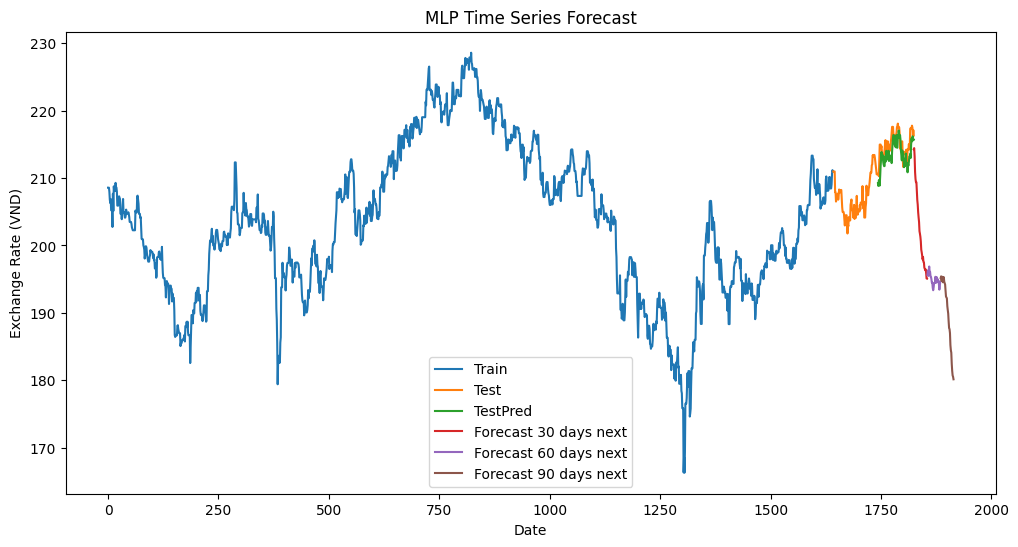

- Test: 
RMSE = 2.0609104588479723
MAPE = 0.7864268019395989
MAE = 1.6935349725649882


In [16]:
implement_MLP(train_gbp_3_sc, test_gbp_3_sc)

# JPY - VND

- **Case 1. 7:3**

C:\Users\TTMC\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
[0.06384967]
101
1 day input [0.02727419 0.02727419 0.02727419 0.03465426 0.04139259 0.06160757
 0.06898765 0.0612867  0.0612867  0.0612867  0.07684903 0.07091288
 0.06866677 0.10717151 0.12000642 0.12000642 0.12000642 0.08471041
 0.10075405 0.09337398 0.17182737 0.17054388 0.17054388 0.17054388
 0.16877908 0.13043478 0.14631798 0.15129151 0.15963421 0.15963421
 0.15963421 0.15754853 0.16348468 0.16300337 0.18626665 0.17006257
 0.17006257 0.17006257 0.18305792 0.18145355 0.16781646 0.14310926
 0.11856249 0.11856249 0.11856249 0.12754693 0.1384566  0.12642387
 0.12145034 0.13396438 0.13396438 0.13396438 0.12112947 0.11070111
 0.08406867 0.08535216 0.08390823 0.08390823 0.08390823 0.08214343
 0.09112787 0.09898925 0.09754532 0.09401572 0.09401572 0.09401572
 0.08615434 0.07781165 0.08118081 0.08968394 0.08454998 0.08454998
 0.08454998 0.05647361 0.0524627  0.07059201 0.05888015 0.04684742
 0.04684742 0.04684742 0.0506979  0.04251564 0.02583026 0.03

8 day output [[0.07593391]]
9 day input [0.0612867  0.0612867  0.07684903 0.07091288 0.06866677 0.10717151
 0.12000642 0.12000642 0.12000642 0.08471041 0.10075405 0.09337398
 0.17182737 0.17054388 0.17054388 0.17054388 0.16877908 0.13043478
 0.14631798 0.15129151 0.15963421 0.15963421 0.15963421 0.15754853
 0.16348468 0.16300337 0.18626665 0.17006257 0.17006257 0.17006257
 0.18305792 0.18145355 0.16781646 0.14310926 0.11856249 0.11856249
 0.11856249 0.12754693 0.1384566  0.12642387 0.12145034 0.13396438
 0.13396438 0.13396438 0.12112947 0.11070111 0.08406867 0.08535216
 0.08390823 0.08390823 0.08390823 0.08214343 0.09112787 0.09898925
 0.09754532 0.09401572 0.09401572 0.09401572 0.08615434 0.07781165
 0.08118081 0.08968394 0.08454998 0.08454998 0.08454998 0.05647361
 0.0524627  0.07059201 0.05888015 0.04684742 0.04684742 0.04684742
 0.0506979  0.04251564 0.02583026 0.03818386 0.0454035  0.0454035
 0.0454035  0.04957484 0.04219477 0.04524306 0.05053746 0.04989572
 0.04989572 0.04989572 

16 day output [[0.07215629]]
17 day input [0.12000642 0.08471041 0.10075405 0.09337398 0.17182737 0.17054388
 0.17054388 0.17054388 0.16877908 0.13043478 0.14631798 0.15129151
 0.15963421 0.15963421 0.15963421 0.15754853 0.16348468 0.16300337
 0.18626665 0.17006257 0.17006257 0.17006257 0.18305792 0.18145355
 0.16781646 0.14310926 0.11856249 0.11856249 0.11856249 0.12754693
 0.1384566  0.12642387 0.12145034 0.13396438 0.13396438 0.13396438
 0.12112947 0.11070111 0.08406867 0.08535216 0.08390823 0.08390823
 0.08390823 0.08214343 0.09112787 0.09898925 0.09754532 0.09401572
 0.09401572 0.09401572 0.08615434 0.07781165 0.08118081 0.08968394
 0.08454998 0.08454998 0.08454998 0.05647361 0.0524627  0.07059201
 0.05888015 0.04684742 0.04684742 0.04684742 0.0506979  0.04251564
 0.02583026 0.03818386 0.0454035  0.0454035  0.0454035  0.04957484
 0.04219477 0.04524306 0.05053746 0.04989572 0.04989572 0.04989572
 0.05519012 0.05310444 0.04412001 0.06369325 0.04700786 0.06384967
 0.06162184 0.066276

26 day output [[0.04642315]]
27 day input [0.14631798 0.15129151 0.15963421 0.15963421 0.15963421 0.15754853
 0.16348468 0.16300337 0.18626665 0.17006257 0.17006257 0.17006257
 0.18305792 0.18145355 0.16781646 0.14310926 0.11856249 0.11856249
 0.11856249 0.12754693 0.1384566  0.12642387 0.12145034 0.13396438
 0.13396438 0.13396438 0.12112947 0.11070111 0.08406867 0.08535216
 0.08390823 0.08390823 0.08390823 0.08214343 0.09112787 0.09898925
 0.09754532 0.09401572 0.09401572 0.09401572 0.08615434 0.07781165
 0.08118081 0.08968394 0.08454998 0.08454998 0.08454998 0.05647361
 0.0524627  0.07059201 0.05888015 0.04684742 0.04684742 0.04684742
 0.0506979  0.04251564 0.02583026 0.03818386 0.0454035  0.0454035
 0.0454035  0.04957484 0.04219477 0.04524306 0.05053746 0.04989572
 0.04989572 0.04989572 0.05519012 0.05310444 0.04412001 0.06369325
 0.04700786 0.06384967 0.06162184 0.06627692 0.07713832 0.08101821
 0.08009378 0.08223375 0.08363095 0.07593391 0.0850648  0.08548413
 0.09536978 0.0854192

36 day output [[0.02356942]]
37 day input [0.17006257 0.17006257 0.18305792 0.18145355 0.16781646 0.14310926
 0.11856249 0.11856249 0.11856249 0.12754693 0.1384566  0.12642387
 0.12145034 0.13396438 0.13396438 0.13396438 0.12112947 0.11070111
 0.08406867 0.08535216 0.08390823 0.08390823 0.08390823 0.08214343
 0.09112787 0.09898925 0.09754532 0.09401572 0.09401572 0.09401572
 0.08615434 0.07781165 0.08118081 0.08968394 0.08454998 0.08454998
 0.08454998 0.05647361 0.0524627  0.07059201 0.05888015 0.04684742
 0.04684742 0.04684742 0.0506979  0.04251564 0.02583026 0.03818386
 0.0454035  0.0454035  0.0454035  0.04957484 0.04219477 0.04524306
 0.05053746 0.04989572 0.04989572 0.04989572 0.05519012 0.05310444
 0.04412001 0.06369325 0.04700786 0.06384967 0.06162184 0.06627692
 0.07713832 0.08101821 0.08009378 0.08223375 0.08363095 0.07593391
 0.0850648  0.08548413 0.09536978 0.08541927 0.08124088 0.07542457
 0.07020523 0.07215629 0.07212517 0.07624866 0.08579952 0.070693
 0.07302998 0.05839484

46 day output [[-0.00923305]]
47 day input [ 0.1384566   0.12642387  0.12145034  0.13396438  0.13396438  0.13396438
  0.12112947  0.11070111  0.08406867  0.08535216  0.08390823  0.08390823
  0.08390823  0.08214343  0.09112787  0.09898925  0.09754532  0.09401572
  0.09401572  0.09401572  0.08615434  0.07781165  0.08118081  0.08968394
  0.08454998  0.08454998  0.08454998  0.05647361  0.0524627   0.07059201
  0.05888015  0.04684742  0.04684742  0.04684742  0.0506979   0.04251564
  0.02583026  0.03818386  0.0454035   0.0454035   0.0454035   0.04957484
  0.04219477  0.04524306  0.05053746  0.04989572  0.04989572  0.04989572
  0.05519012  0.05310444  0.04412001  0.06369325  0.04700786  0.06384967
  0.06162184  0.06627692  0.07713832  0.08101821  0.08009378  0.08223375
  0.08363095  0.07593391  0.0850648   0.08548413  0.09536978  0.08541927
  0.08124088  0.07542457  0.07020523  0.07215629  0.07212517  0.07624866
  0.08579952  0.070693    0.07302998  0.05839484  0.06648591  0.05490855
  0.0583

56 day output [[-0.00832371]]
57 day input [ 0.08390823  0.08390823  0.08390823  0.08214343  0.09112787  0.09898925
  0.09754532  0.09401572  0.09401572  0.09401572  0.08615434  0.07781165
  0.08118081  0.08968394  0.08454998  0.08454998  0.08454998  0.05647361
  0.0524627   0.07059201  0.05888015  0.04684742  0.04684742  0.04684742
  0.0506979   0.04251564  0.02583026  0.03818386  0.0454035   0.0454035
  0.0454035   0.04957484  0.04219477  0.04524306  0.05053746  0.04989572
  0.04989572  0.04989572  0.05519012  0.05310444  0.04412001  0.06369325
  0.04700786  0.06384967  0.06162184  0.06627692  0.07713832  0.08101821
  0.08009378  0.08223375  0.08363095  0.07593391  0.0850648   0.08548413
  0.09536978  0.08541927  0.08124088  0.07542457  0.07020523  0.07215629
  0.07212517  0.07624866  0.08579952  0.070693    0.07302998  0.05839484
  0.06648591  0.05490855  0.05836819  0.04642315  0.03694518  0.03897523
  0.04478118  0.0442454   0.03517256  0.02690827  0.02742182  0.02007885
  0.02473

66 day output [[0.00853204]]
67 day input [ 0.08615434  0.07781165  0.08118081  0.08968394  0.08454998  0.08454998
  0.08454998  0.05647361  0.0524627   0.07059201  0.05888015  0.04684742
  0.04684742  0.04684742  0.0506979   0.04251564  0.02583026  0.03818386
  0.0454035   0.0454035   0.0454035   0.04957484  0.04219477  0.04524306
  0.05053746  0.04989572  0.04989572  0.04989572  0.05519012  0.05310444
  0.04412001  0.06369325  0.04700786  0.06384967  0.06162184  0.06627692
  0.07713832  0.08101821  0.08009378  0.08223375  0.08363095  0.07593391
  0.0850648   0.08548413  0.09536978  0.08541927  0.08124088  0.07542457
  0.07020523  0.07215629  0.07212517  0.07624866  0.08579952  0.070693
  0.07302998  0.05839484  0.06648591  0.05490855  0.05836819  0.04642315
  0.03694518  0.03897523  0.04478118  0.0442454   0.03517256  0.02690827
  0.02742182  0.02007885  0.0247359   0.02356942  0.01441507  0.01735434
  0.00666046  0.00115113  0.00366713  0.01170805 -0.00084176 -0.00152771
 -0.0042636

76 day output [[0.0207772]]
77 day input [ 0.05888015  0.04684742  0.04684742  0.04684742  0.0506979   0.04251564
  0.02583026  0.03818386  0.0454035   0.0454035   0.0454035   0.04957484
  0.04219477  0.04524306  0.05053746  0.04989572  0.04989572  0.04989572
  0.05519012  0.05310444  0.04412001  0.06369325  0.04700786  0.06384967
  0.06162184  0.06627692  0.07713832  0.08101821  0.08009378  0.08223375
  0.08363095  0.07593391  0.0850648   0.08548413  0.09536978  0.08541927
  0.08124088  0.07542457  0.07020523  0.07215629  0.07212517  0.07624866
  0.08579952  0.070693    0.07302998  0.05839484  0.06648591  0.05490855
  0.05836819  0.04642315  0.03694518  0.03897523  0.04478118  0.0442454
  0.03517256  0.02690827  0.02742182  0.02007885  0.0247359   0.02356942
  0.01441507  0.01735434  0.00666046  0.00115113  0.00366713  0.01170805
 -0.00084176 -0.00152771 -0.00426365 -0.00923305 -0.0023025   0.00357418
 -0.00421701 -0.00515604 -0.00667043 -0.00634379 -0.0117554  -0.00760484
 -0.0056170

86 day output [[0.02086853]]
87 day input [ 0.0454035   0.04957484  0.04219477  0.04524306  0.05053746  0.04989572
  0.04989572  0.04989572  0.05519012  0.05310444  0.04412001  0.06369325
  0.04700786  0.06384967  0.06162184  0.06627692  0.07713832  0.08101821
  0.08009378  0.08223375  0.08363095  0.07593391  0.0850648   0.08548413
  0.09536978  0.08541927  0.08124088  0.07542457  0.07020523  0.07215629
  0.07212517  0.07624866  0.08579952  0.070693    0.07302998  0.05839484
  0.06648591  0.05490855  0.05836819  0.04642315  0.03694518  0.03897523
  0.04478118  0.0442454   0.03517256  0.02690827  0.02742182  0.02007885
  0.0247359   0.02356942  0.01441507  0.01735434  0.00666046  0.00115113
  0.00366713  0.01170805 -0.00084176 -0.00152771 -0.00426365 -0.00923305
 -0.0023025   0.00357418 -0.00421701 -0.00515604 -0.00667043 -0.00634379
 -0.0117554  -0.00760484 -0.00561708 -0.00832371 -0.01051331 -0.00554841
 -0.00767921  0.00582961  0.01004371 -0.00537629  0.00663901 -0.00697876
  0.00216

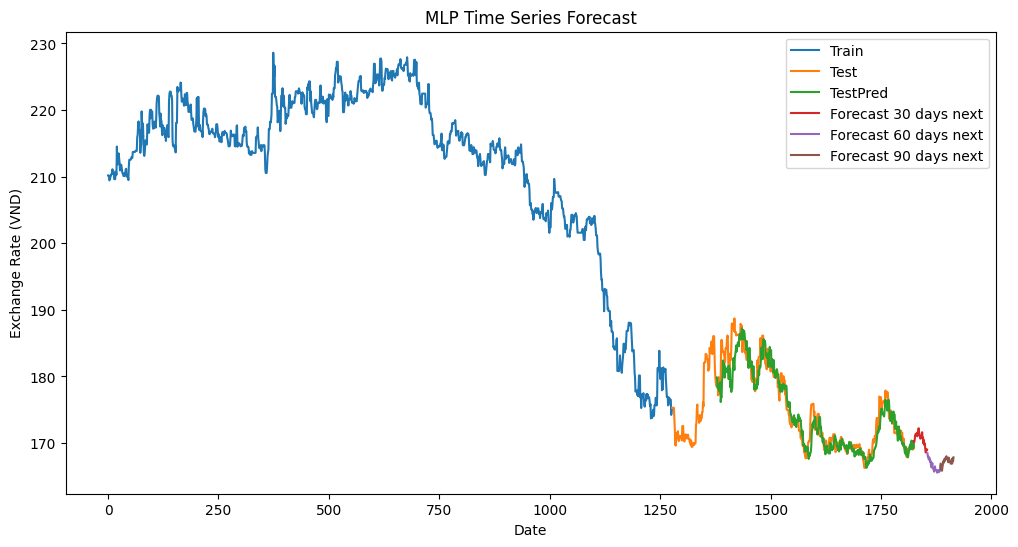

- Test: 
RMSE = 2.012285940853761
MAPE = 0.7994997955824497
MAE = 1.4192459031346127


In [17]:
implement_MLP(train_jpy_1_sc, test_jpy_1_sc)

- **Case 2. 8:2**

C:\Users\TTMC\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
[0.06124449]
101
1 day input [0.02727419 0.02727419 0.02727419 0.03465426 0.04139259 0.06160757
 0.06898765 0.0612867  0.0612867  0.0612867  0.07684903 0.07091288
 0.06866677 0.10717151 0.12000642 0.12000642 0.12000642 0.08471041
 0.10075405 0.09337398 0.17182737 0.17054388 0.17054388 0.17054388
 0.16877908 0.13043478 0.14631798 0.15129151 0.15963421 0.15963421
 0.15963421 0.15754853 0.16348468 0.16300337 0.18626665 0.17006257
 0.17006257 0.17006257 0.18305792 0.18145355 0.16781646 0.14310926
 0.11856249 0.11856249 0.11856249 0.12754693 0.1384566  0.12642387
 0.12145034 0.13396438 0.13396438 0.13396438 0.12112947 0.11070111
 0.08406867 0.08535216 0.08390823 0.08390823 0.08390823 0.08214343
 0.09112787 0.09898925 0.09754532 0.09401572 0.09401572 0.09401572
 0.08615434 0.07781165 0.08118081 0.08968394 0.08454998 0.08454998
 0.08454998 0.05647361 0.0524627  0.07059201 0.05888015 0.04684742
 0.04684742 0.04684742 0.0506979  0.04251564 0.02583026 0.0381

8 day output [[0.04111607]]
9 day input [0.0612867  0.0612867  0.07684903 0.07091288 0.06866677 0.10717151
 0.12000642 0.12000642 0.12000642 0.08471041 0.10075405 0.09337398
 0.17182737 0.17054388 0.17054388 0.17054388 0.16877908 0.13043478
 0.14631798 0.15129151 0.15963421 0.15963421 0.15963421 0.15754853
 0.16348468 0.16300337 0.18626665 0.17006257 0.17006257 0.17006257
 0.18305792 0.18145355 0.16781646 0.14310926 0.11856249 0.11856249
 0.11856249 0.12754693 0.1384566  0.12642387 0.12145034 0.13396438
 0.13396438 0.13396438 0.12112947 0.11070111 0.08406867 0.08535216
 0.08390823 0.08390823 0.08390823 0.08214343 0.09112787 0.09898925
 0.09754532 0.09401572 0.09401572 0.09401572 0.08615434 0.07781165
 0.08118081 0.08968394 0.08454998 0.08454998 0.08454998 0.05647361
 0.0524627  0.07059201 0.05888015 0.04684742 0.04684742 0.04684742
 0.0506979  0.04251564 0.02583026 0.03818386 0.0454035  0.0454035
 0.0454035  0.04957484 0.04219477 0.04524306 0.05053746 0.04989572
 0.04989572 0.04989572 

19 day output [[0.04425198]]
20 day input [0.09337398 0.17182737 0.17054388 0.17054388 0.17054388 0.16877908
 0.13043478 0.14631798 0.15129151 0.15963421 0.15963421 0.15963421
 0.15754853 0.16348468 0.16300337 0.18626665 0.17006257 0.17006257
 0.17006257 0.18305792 0.18145355 0.16781646 0.14310926 0.11856249
 0.11856249 0.11856249 0.12754693 0.1384566  0.12642387 0.12145034
 0.13396438 0.13396438 0.13396438 0.12112947 0.11070111 0.08406867
 0.08535216 0.08390823 0.08390823 0.08390823 0.08214343 0.09112787
 0.09898925 0.09754532 0.09401572 0.09401572 0.09401572 0.08615434
 0.07781165 0.08118081 0.08968394 0.08454998 0.08454998 0.08454998
 0.05647361 0.0524627  0.07059201 0.05888015 0.04684742 0.04684742
 0.04684742 0.0506979  0.04251564 0.02583026 0.03818386 0.0454035
 0.0454035  0.0454035  0.04957484 0.04219477 0.04524306 0.05053746
 0.04989572 0.04989572 0.04989572 0.05519012 0.05310444 0.04412001
 0.06369325 0.04700786 0.06124449 0.05217142 0.04961247 0.04905891
 0.05024447 0.0512285

29 day output [[0.11748318]]
30 day input [0.15963421 0.15963421 0.15754853 0.16348468 0.16300337 0.18626665
 0.17006257 0.17006257 0.17006257 0.18305792 0.18145355 0.16781646
 0.14310926 0.11856249 0.11856249 0.11856249 0.12754693 0.1384566
 0.12642387 0.12145034 0.13396438 0.13396438 0.13396438 0.12112947
 0.11070111 0.08406867 0.08535216 0.08390823 0.08390823 0.08390823
 0.08214343 0.09112787 0.09898925 0.09754532 0.09401572 0.09401572
 0.09401572 0.08615434 0.07781165 0.08118081 0.08968394 0.08454998
 0.08454998 0.08454998 0.05647361 0.0524627  0.07059201 0.05888015
 0.04684742 0.04684742 0.04684742 0.0506979  0.04251564 0.02583026
 0.03818386 0.0454035  0.0454035  0.0454035  0.04957484 0.04219477
 0.04524306 0.05053746 0.04989572 0.04989572 0.04989572 0.05519012
 0.05310444 0.04412001 0.06369325 0.04700786 0.06124449 0.05217142
 0.04961247 0.04905891 0.05024447 0.05122859 0.05820335 0.05585304
 0.04111607 0.03599475 0.03678207 0.04703903 0.05978835 0.05665827
 0.06841774 0.0528472

40 day output [[0.21818946]]
41 day input [0.16781646 0.14310926 0.11856249 0.11856249 0.11856249 0.12754693
 0.1384566  0.12642387 0.12145034 0.13396438 0.13396438 0.13396438
 0.12112947 0.11070111 0.08406867 0.08535216 0.08390823 0.08390823
 0.08390823 0.08214343 0.09112787 0.09898925 0.09754532 0.09401572
 0.09401572 0.09401572 0.08615434 0.07781165 0.08118081 0.08968394
 0.08454998 0.08454998 0.08454998 0.05647361 0.0524627  0.07059201
 0.05888015 0.04684742 0.04684742 0.04684742 0.0506979  0.04251564
 0.02583026 0.03818386 0.0454035  0.0454035  0.0454035  0.04957484
 0.04219477 0.04524306 0.05053746 0.04989572 0.04989572 0.04989572
 0.05519012 0.05310444 0.04412001 0.06369325 0.04700786 0.06124449
 0.05217142 0.04961247 0.04905891 0.05024447 0.05122859 0.05820335
 0.05585304 0.04111607 0.03599475 0.03678207 0.04703903 0.05978835
 0.05665827 0.06841774 0.05284727 0.04387978 0.04395571 0.03792115
 0.04425198 0.03614576 0.05335367 0.0674144  0.07333575 0.07926764
 0.08759168 0.093926

51 day output [[0.30867177]]
52 day input [0.13396438 0.12112947 0.11070111 0.08406867 0.08535216 0.08390823
 0.08390823 0.08390823 0.08214343 0.09112787 0.09898925 0.09754532
 0.09401572 0.09401572 0.09401572 0.08615434 0.07781165 0.08118081
 0.08968394 0.08454998 0.08454998 0.08454998 0.05647361 0.0524627
 0.07059201 0.05888015 0.04684742 0.04684742 0.04684742 0.0506979
 0.04251564 0.02583026 0.03818386 0.0454035  0.0454035  0.0454035
 0.04957484 0.04219477 0.04524306 0.05053746 0.04989572 0.04989572
 0.04989572 0.05519012 0.05310444 0.04412001 0.06369325 0.04700786
 0.06124449 0.05217142 0.04961247 0.04905891 0.05024447 0.05122859
 0.05820335 0.05585304 0.04111607 0.03599475 0.03678207 0.04703903
 0.05978835 0.05665827 0.06841774 0.05284727 0.04387978 0.04395571
 0.03792115 0.04425198 0.03614576 0.05335367 0.0674144  0.07333575
 0.07926764 0.08759168 0.09392623 0.09934761 0.09747649 0.11748318
 0.11111061 0.12897749 0.13299565 0.14052722 0.14391556 0.14770566
 0.16014977 0.17170273 

61 day output [[0.14975235]]
62 day input [0.09898925 0.09754532 0.09401572 0.09401572 0.09401572 0.08615434
 0.07781165 0.08118081 0.08968394 0.08454998 0.08454998 0.08454998
 0.05647361 0.0524627  0.07059201 0.05888015 0.04684742 0.04684742
 0.04684742 0.0506979  0.04251564 0.02583026 0.03818386 0.0454035
 0.0454035  0.0454035  0.04957484 0.04219477 0.04524306 0.05053746
 0.04989572 0.04989572 0.04989572 0.05519012 0.05310444 0.04412001
 0.06369325 0.04700786 0.06124449 0.05217142 0.04961247 0.04905891
 0.05024447 0.05122859 0.05820335 0.05585304 0.04111607 0.03599475
 0.03678207 0.04703903 0.05978835 0.05665827 0.06841774 0.05284727
 0.04387978 0.04395571 0.03792115 0.04425198 0.03614576 0.05335367
 0.0674144  0.07333575 0.07926764 0.08759168 0.09392623 0.09934761
 0.09747649 0.11748318 0.11111061 0.12897749 0.13299565 0.14052722
 0.14391556 0.14770566 0.16014977 0.17170273 0.17964348 0.2066011
 0.21818946 0.25209859 0.26897809 0.27802354 0.27778846 0.28865895
 0.29120952 0.29862517

71 day output [[0.13378172]]
72 day input [0.08454998 0.08454998 0.05647361 0.0524627  0.07059201 0.05888015
 0.04684742 0.04684742 0.04684742 0.0506979  0.04251564 0.02583026
 0.03818386 0.0454035  0.0454035  0.0454035  0.04957484 0.04219477
 0.04524306 0.05053746 0.04989572 0.04989572 0.04989572 0.05519012
 0.05310444 0.04412001 0.06369325 0.04700786 0.06124449 0.05217142
 0.04961247 0.04905891 0.05024447 0.05122859 0.05820335 0.05585304
 0.04111607 0.03599475 0.03678207 0.04703903 0.05978835 0.05665827
 0.06841774 0.05284727 0.04387978 0.04395571 0.03792115 0.04425198
 0.03614576 0.05335367 0.0674144  0.07333575 0.07926764 0.08759168
 0.09392623 0.09934761 0.09747649 0.11748318 0.11111061 0.12897749
 0.13299565 0.14052722 0.14391556 0.14770566 0.16014977 0.17170273
 0.17964348 0.2066011  0.21818946 0.25209859 0.26897809 0.27802354
 0.27778846 0.28865895 0.29120952 0.29862517 0.30883259 0.30971032
 0.30434582 0.30867177 0.29852864 0.29111356 0.28033608 0.26038098
 0.24566106 0.219734

81 day output [[0.16740371]]
82 day input [0.04251564 0.02583026 0.03818386 0.0454035  0.0454035  0.0454035
 0.04957484 0.04219477 0.04524306 0.05053746 0.04989572 0.04989572
 0.04989572 0.05519012 0.05310444 0.04412001 0.06369325 0.04700786
 0.06124449 0.05217142 0.04961247 0.04905891 0.05024447 0.05122859
 0.05820335 0.05585304 0.04111607 0.03599475 0.03678207 0.04703903
 0.05978835 0.05665827 0.06841774 0.05284727 0.04387978 0.04395571
 0.03792115 0.04425198 0.03614576 0.05335367 0.0674144  0.07333575
 0.07926764 0.08759168 0.09392623 0.09934761 0.09747649 0.11748318
 0.11111061 0.12897749 0.13299565 0.14052722 0.14391556 0.14770566
 0.16014977 0.17170273 0.17964348 0.2066011  0.21818946 0.25209859
 0.26897809 0.27802354 0.27778846 0.28865895 0.29120952 0.29862517
 0.30883259 0.30971032 0.30434582 0.30867177 0.29852864 0.29111356
 0.28033608 0.26038098 0.24566106 0.21973453 0.2039794  0.18048969
 0.16047676 0.14975235 0.13807838 0.12033674 0.10180949 0.09492436
 0.09791339 0.1053529

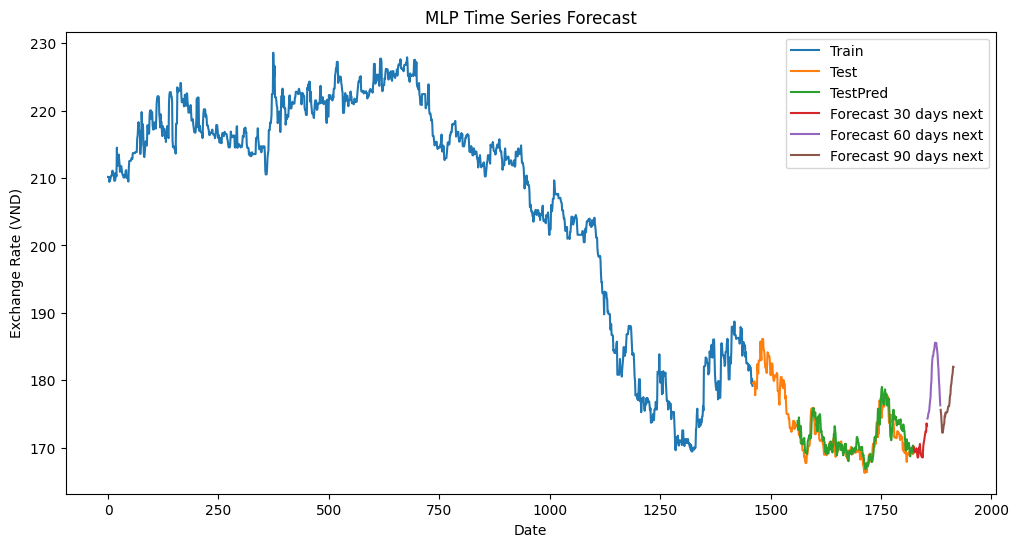

- Test: 
RMSE = 1.5616003219774324
MAPE = 0.7191720137012657
MAE = 1.2312207771070085


In [18]:
implement_MLP(train_jpy_2_sc, test_jpy_2_sc)

- **Case 3. 9:1**

C:\Users\TTMC\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
[0.05540371]
101
1 day input [0.02727419 0.02727419 0.02727419 0.03465426 0.04139259 0.06160757
 0.06898765 0.0612867  0.0612867  0.0612867  0.07684903 0.07091288
 0.06866677 0.10717151 0.12000642 0.12000642 0.12000642 0.08471041
 0.10075405 0.09337398 0.17182737 0.17054388 0.17054388 0.17054388
 0.16877908 0.13043478 0.14631798 0.15129151 0.15963421 0.15963421
 0.15963421 0.15754853 0.16348468 0.16300337 0.18626665 0.17006257
 0.17006257 0.17006257 0.18305792 0.18145355 0.16781646 0.14310926
 0.11856249 0.11856249 0.11856249 0.12754693 0.1384566  0.12642387
 0.12145034 0.13396438 0.13396438 0.13396438 0.12112947 0.11070111
 0.08406867 0.08535216 0.08390823 0.08390823 0.08390823 0.08214343
 0.09112787 0.09898925 0.09754532 0.09401572 0.09401572 0.09401572
 0.08615434 0.07781165 0.08118081 0.08968394 0.08454998 0.08454998
 0.08454998 0.05647361 0.0524627  0.07059201 0.05888015 0.04684742
 0.04684742 0.04684742 0.0506979  0.04251564 0.02583026 0.0381

9 day output [[0.05163553]]
10 day input [0.0612867  0.07684903 0.07091288 0.06866677 0.10717151 0.12000642
 0.12000642 0.12000642 0.08471041 0.10075405 0.09337398 0.17182737
 0.17054388 0.17054388 0.17054388 0.16877908 0.13043478 0.14631798
 0.15129151 0.15963421 0.15963421 0.15963421 0.15754853 0.16348468
 0.16300337 0.18626665 0.17006257 0.17006257 0.17006257 0.18305792
 0.18145355 0.16781646 0.14310926 0.11856249 0.11856249 0.11856249
 0.12754693 0.1384566  0.12642387 0.12145034 0.13396438 0.13396438
 0.13396438 0.12112947 0.11070111 0.08406867 0.08535216 0.08390823
 0.08390823 0.08390823 0.08214343 0.09112787 0.09898925 0.09754532
 0.09401572 0.09401572 0.09401572 0.08615434 0.07781165 0.08118081
 0.08968394 0.08454998 0.08454998 0.08454998 0.05647361 0.0524627
 0.07059201 0.05888015 0.04684742 0.04684742 0.04684742 0.0506979
 0.04251564 0.02583026 0.03818386 0.0454035  0.0454035  0.0454035
 0.04957484 0.04219477 0.04524306 0.05053746 0.04989572 0.04989572
 0.04989572 0.05519012 0

19 day output [[0.04747467]]
20 day input [0.09337398 0.17182737 0.17054388 0.17054388 0.17054388 0.16877908
 0.13043478 0.14631798 0.15129151 0.15963421 0.15963421 0.15963421
 0.15754853 0.16348468 0.16300337 0.18626665 0.17006257 0.17006257
 0.17006257 0.18305792 0.18145355 0.16781646 0.14310926 0.11856249
 0.11856249 0.11856249 0.12754693 0.1384566  0.12642387 0.12145034
 0.13396438 0.13396438 0.13396438 0.12112947 0.11070111 0.08406867
 0.08535216 0.08390823 0.08390823 0.08390823 0.08214343 0.09112787
 0.09898925 0.09754532 0.09401572 0.09401572 0.09401572 0.08615434
 0.07781165 0.08118081 0.08968394 0.08454998 0.08454998 0.08454998
 0.05647361 0.0524627  0.07059201 0.05888015 0.04684742 0.04684742
 0.04684742 0.0506979  0.04251564 0.02583026 0.03818386 0.0454035
 0.0454035  0.0454035  0.04957484 0.04219477 0.04524306 0.05053746
 0.04989572 0.04989572 0.04989572 0.05519012 0.05310444 0.04412001
 0.06369325 0.04700786 0.05540371 0.055323   0.04507576 0.0497736
 0.05254343 0.05068014

27 day output [[0.07452901]]
28 day input [0.15129151 0.15963421 0.15963421 0.15963421 0.15754853 0.16348468
 0.16300337 0.18626665 0.17006257 0.17006257 0.17006257 0.18305792
 0.18145355 0.16781646 0.14310926 0.11856249 0.11856249 0.11856249
 0.12754693 0.1384566  0.12642387 0.12145034 0.13396438 0.13396438
 0.13396438 0.12112947 0.11070111 0.08406867 0.08535216 0.08390823
 0.08390823 0.08390823 0.08214343 0.09112787 0.09898925 0.09754532
 0.09401572 0.09401572 0.09401572 0.08615434 0.07781165 0.08118081
 0.08968394 0.08454998 0.08454998 0.08454998 0.05647361 0.0524627
 0.07059201 0.05888015 0.04684742 0.04684742 0.04684742 0.0506979
 0.04251564 0.02583026 0.03818386 0.0454035  0.0454035  0.0454035
 0.04957484 0.04219477 0.04524306 0.05053746 0.04989572 0.04989572
 0.04989572 0.05519012 0.05310444 0.04412001 0.06369325 0.04700786
 0.05540371 0.055323   0.04507576 0.0497736  0.05254343 0.05068014
 0.04838784 0.04496208 0.05414223 0.05163553 0.04191187 0.05918109
 0.04732298 0.04890905 

35 day output [[0.09473093]]
36 day input [0.17006257 0.17006257 0.17006257 0.18305792 0.18145355 0.16781646
 0.14310926 0.11856249 0.11856249 0.11856249 0.12754693 0.1384566
 0.12642387 0.12145034 0.13396438 0.13396438 0.13396438 0.12112947
 0.11070111 0.08406867 0.08535216 0.08390823 0.08390823 0.08390823
 0.08214343 0.09112787 0.09898925 0.09754532 0.09401572 0.09401572
 0.09401572 0.08615434 0.07781165 0.08118081 0.08968394 0.08454998
 0.08454998 0.08454998 0.05647361 0.0524627  0.07059201 0.05888015
 0.04684742 0.04684742 0.04684742 0.0506979  0.04251564 0.02583026
 0.03818386 0.0454035  0.0454035  0.0454035  0.04957484 0.04219477
 0.04524306 0.05053746 0.04989572 0.04989572 0.04989572 0.05519012
 0.05310444 0.04412001 0.06369325 0.04700786 0.05540371 0.055323
 0.04507576 0.0497736  0.05254343 0.05068014 0.04838784 0.04496208
 0.05414223 0.05163553 0.04191187 0.05918109 0.04732298 0.04890905
 0.06839103 0.05151924 0.04590574 0.03915958 0.02993011 0.04747467
 0.0383957  0.05321516 

43 day output [[0.12516278]]
44 day input [0.11856249 0.11856249 0.12754693 0.1384566  0.12642387 0.12145034
 0.13396438 0.13396438 0.13396438 0.12112947 0.11070111 0.08406867
 0.08535216 0.08390823 0.08390823 0.08390823 0.08214343 0.09112787
 0.09898925 0.09754532 0.09401572 0.09401572 0.09401572 0.08615434
 0.07781165 0.08118081 0.08968394 0.08454998 0.08454998 0.08454998
 0.05647361 0.0524627  0.07059201 0.05888015 0.04684742 0.04684742
 0.04684742 0.0506979  0.04251564 0.02583026 0.03818386 0.0454035
 0.0454035  0.0454035  0.04957484 0.04219477 0.04524306 0.05053746
 0.04989572 0.04989572 0.04989572 0.05519012 0.05310444 0.04412001
 0.06369325 0.04700786 0.05540371 0.055323   0.04507576 0.0497736
 0.05254343 0.05068014 0.04838784 0.04496208 0.05414223 0.05163553
 0.04191187 0.05918109 0.04732298 0.04890905 0.06839103 0.05151924
 0.04590574 0.03915958 0.02993011 0.04747467 0.0383957  0.05321516
 0.06453825 0.05495755 0.06378922 0.06750077 0.06807826 0.07452901
 0.06522521 0.08126711

51 day output [[0.14710508]]
52 day input [0.13396438 0.12112947 0.11070111 0.08406867 0.08535216 0.08390823
 0.08390823 0.08390823 0.08214343 0.09112787 0.09898925 0.09754532
 0.09401572 0.09401572 0.09401572 0.08615434 0.07781165 0.08118081
 0.08968394 0.08454998 0.08454998 0.08454998 0.05647361 0.0524627
 0.07059201 0.05888015 0.04684742 0.04684742 0.04684742 0.0506979
 0.04251564 0.02583026 0.03818386 0.0454035  0.0454035  0.0454035
 0.04957484 0.04219477 0.04524306 0.05053746 0.04989572 0.04989572
 0.04989572 0.05519012 0.05310444 0.04412001 0.06369325 0.04700786
 0.05540371 0.055323   0.04507576 0.0497736  0.05254343 0.05068014
 0.04838784 0.04496208 0.05414223 0.05163553 0.04191187 0.05918109
 0.04732298 0.04890905 0.06839103 0.05151924 0.04590574 0.03915958
 0.02993011 0.04747467 0.0383957  0.05321516 0.06453825 0.05495755
 0.06378922 0.06750077 0.06807826 0.07452901 0.06522521 0.08126711
 0.07887411 0.07611328 0.08607191 0.09024927 0.09659084 0.09473093
 0.09212636 0.10595924 

62 day output [[0.15876403]]
63 day input [0.09754532 0.09401572 0.09401572 0.09401572 0.08615434 0.07781165
 0.08118081 0.08968394 0.08454998 0.08454998 0.08454998 0.05647361
 0.0524627  0.07059201 0.05888015 0.04684742 0.04684742 0.04684742
 0.0506979  0.04251564 0.02583026 0.03818386 0.0454035  0.0454035
 0.0454035  0.04957484 0.04219477 0.04524306 0.05053746 0.04989572
 0.04989572 0.04989572 0.05519012 0.05310444 0.04412001 0.06369325
 0.04700786 0.05540371 0.055323   0.04507576 0.0497736  0.05254343
 0.05068014 0.04838784 0.04496208 0.05414223 0.05163553 0.04191187
 0.05918109 0.04732298 0.04890905 0.06839103 0.05151924 0.04590574
 0.03915958 0.02993011 0.04747467 0.0383957  0.05321516 0.06453825
 0.05495755 0.06378922 0.06750077 0.06807826 0.07452901 0.06522521
 0.08126711 0.07887411 0.07611328 0.08607191 0.09024927 0.09659084
 0.09473093 0.09212636 0.10595924 0.10306965 0.11353914 0.12378466
 0.11518406 0.1270466  0.12516278 0.12689289 0.13806909 0.12894385
 0.13855904 0.1391079

72 day output [[0.14983776]]
73 day input [0.08454998 0.05647361 0.0524627  0.07059201 0.05888015 0.04684742
 0.04684742 0.04684742 0.0506979  0.04251564 0.02583026 0.03818386
 0.0454035  0.0454035  0.0454035  0.04957484 0.04219477 0.04524306
 0.05053746 0.04989572 0.04989572 0.04989572 0.05519012 0.05310444
 0.04412001 0.06369325 0.04700786 0.05540371 0.055323   0.04507576
 0.0497736  0.05254343 0.05068014 0.04838784 0.04496208 0.05414223
 0.05163553 0.04191187 0.05918109 0.04732298 0.04890905 0.06839103
 0.05151924 0.04590574 0.03915958 0.02993011 0.04747467 0.0383957
 0.05321516 0.06453825 0.05495755 0.06378922 0.06750077 0.06807826
 0.07452901 0.06522521 0.08126711 0.07887411 0.07611328 0.08607191
 0.09024927 0.09659084 0.09473093 0.09212636 0.10595924 0.10306965
 0.11353914 0.12378466 0.11518406 0.1270466  0.12516278 0.12689289
 0.13806909 0.12894385 0.13855904 0.13910796 0.13668689 0.15162618
 0.14710508 0.15503103 0.15976402 0.15297979 0.15944482 0.15573519
 0.16373134 0.1613951

83 day output [[0.17982307]]
84 day input [0.03818386 0.0454035  0.0454035  0.0454035  0.04957484 0.04219477
 0.04524306 0.05053746 0.04989572 0.04989572 0.04989572 0.05519012
 0.05310444 0.04412001 0.06369325 0.04700786 0.05540371 0.055323
 0.04507576 0.0497736  0.05254343 0.05068014 0.04838784 0.04496208
 0.05414223 0.05163553 0.04191187 0.05918109 0.04732298 0.04890905
 0.06839103 0.05151924 0.04590574 0.03915958 0.02993011 0.04747467
 0.0383957  0.05321516 0.06453825 0.05495755 0.06378922 0.06750077
 0.06807826 0.07452901 0.06522521 0.08126711 0.07887411 0.07611328
 0.08607191 0.09024927 0.09659084 0.09473093 0.09212636 0.10595924
 0.10306965 0.11353914 0.12378466 0.11518406 0.1270466  0.12516278
 0.12689289 0.13806909 0.12894385 0.13855904 0.13910796 0.13668689
 0.15162618 0.14710508 0.15503103 0.15976402 0.15297979 0.15944482
 0.15573519 0.16373134 0.16139519 0.14574133 0.16748469 0.15868822
 0.15876403 0.16469969 0.15680009 0.15705313 0.15406133 0.14908831
 0.15688418 0.14451161

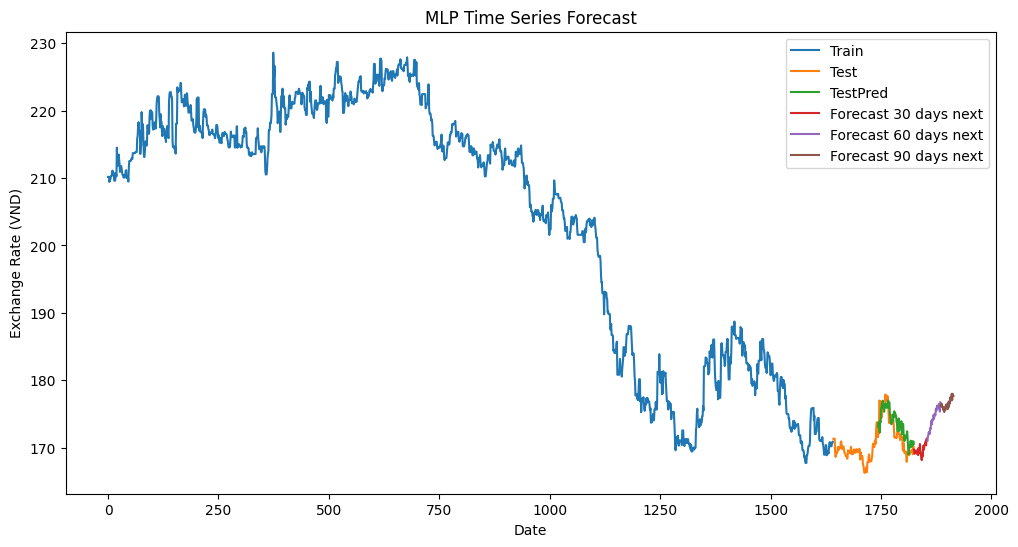

- Test: 
RMSE = 1.9637667702340365
MAPE = 0.9315204611307282
MAE = 1.6033740829839966


In [19]:
implement_MLP(train_jpy_3_sc, test_jpy_3_sc)